<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/Proyecto/Adsorcion%20en%20superficies%20basado%20en%20RIUS%20V%201.0%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera versión del intento de simulación de adsorción basado en el algoritmo de RIUS para pegar iones a superficies



# Hamiltoniano del sistema basico basado en el potencial de lennard-jones

$$ \textit{H}\left ( r_{ij} \right ) = 4\epsilon \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right] $$



# Librerias y Constantes

In [ ]:
#Importamos ls librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
#Definimos las constantes a utilizar
a = 7.9 #Parametro de red (A)
SigmaAl = 3.302 #Radio de vanderwalls del aluminio (A)
EpsilonAl = 7.700e-3 #Fondo del pozo del aluminio (j/mol)
SigmaHg = 2.79 #Radio de vanderwalls del mercurio (A)
EpsilonHg = 10031 #Fondo del pozo mercurio (j/mol)
Sigma = np.sqrt(SigmaAl*SigmaHg)
Epsilon = np.sqrt(EpsilonAl*EpsilonHg)

# Creación de la muestra

9


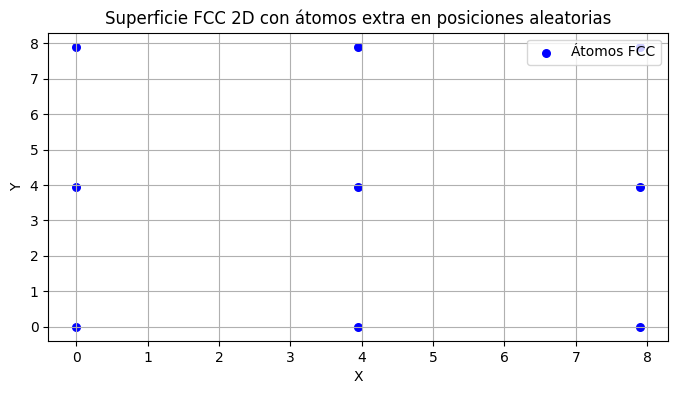

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensiones de la red FCC
celdas_largo = 1
celdas_alto = 1
a = 7.9  # Longitud de la celda unitaria

# Definir los vectores base de una celda unitaria FCC
base_fcc = np.array([[0, 0], [0.5, 0], [0, 0.5], [0.5, 0.5]]) * a

# Crear las posiciones para las celdas unitarias
x, y = [], []
for i in range(celdas_largo):
    for j in range(celdas_alto):
        # Posiciones de átomos en cada celda FCC
        atoms = base_fcc + np.array([i * a, j * a])
        x.extend(atoms[:, 0])
        y.extend(atoms[:, 1])

# Agregar átomos adicionales en la última fila y columna
# Última columna
for j in range(celdas_alto):
    x.append(celdas_largo * a)
    y.append(j * a + 0)  # Átomo en el vértice
    x.append(celdas_largo * a)
    y.append(j * a + 0.5 * a)  # Átomo en el centro de la cara

# Última fila
for i in range(celdas_largo):
    x.append(i * a + 0)
    y.append(celdas_alto * a)
    x.append(i * a + 0.5 * a)
    y.append(celdas_alto * a)

# Añadir el átomo del vértice superior derecho
x.append(celdas_largo * a)
y.append(celdas_alto * a)

fcc_positions = np.column_stack((x, y))  # Matriz con posiciones FCC
num_atoms =fcc_positions.shape[0]
print(num_atoms)
# Graficar la estructura FCC con átomos adicionales
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

# Creación de los iones que se van a adsorber

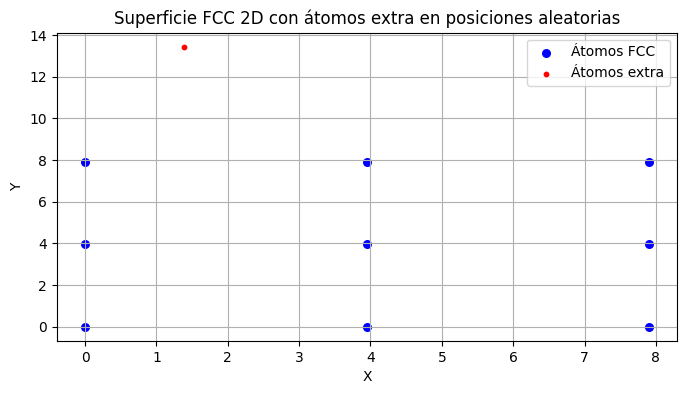

In [ ]:
num_iones = 1  # Número de átomos extra que se colocarán al azar

# Generar átomos adicionales en posiciones aleatorias por encima de la superficie
x_extra = np.random.uniform(0, celdas_largo * a, num_iones)
y_extra = np.random.uniform((celdas_alto * a)+ Sigma , celdas_alto * a + 4*Sigma, num_iones)  # Y mayor que la parte más alta
extra_positions = np.column_stack((x_extra, y_extra))  # Matriz con posiciones de átomos extra

# Graficar las posiciones
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.scatter(extra_positions[:, 0], extra_positions[:, 1], color='red', s=10, label="Átomos extra")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
@tf.function
# Potencial de Lennard-Jones
def lennard_jones_potential(r, epsilon=Epsilon, sigma=Sigma):
    """
    Calcula el potencial de Lennard-Jones para una distancia r.
    """
    sigma = tf.cast(sigma, tf.float32)
    epsilon = tf.cast(epsilon, tf.float32)
    lj_term = (sigma / r)**12 - (sigma / r)**6
    return 4 * epsilon * lj_term + epsilon #Suma epsilon para desplazar el fondo del potencial a 0

# Función de costo para el modelo
def H_loss(Xh, Xt, epsilon=Epsilon, sigma=Sigma,lam_=1.0):
    """
    Calcula la energía total de las interacciones entre los iones (Xh) y la superficie (Xt),
    utilizando el potencial de Lennard-Jones.

    Parameters:
        Xh: tensor con posiciones de los iones (num_iones, 2)
        Xt: tensor con posiciones de los átomos de la superficie (num_superficie, 2)

    Returns:
        Energía promedio del sistema (escalar)
    """
    # Expandir dimensiones para obtener todas las combinaciones de distancias
    diff = tf.expand_dims(Xh, axis=1) - tf.expand_dims(Xt, axis=0)  # (num_iones, num_superficie, 2)
    r = tf.norm(diff, axis=-1)  # Distancia entre cada ion y cada átomo de la superficie (num_iones, num_superficie)

    # Evitar divisiones por cero
    r = tf.where(r == 0, 1e-10, r)

    # Calcular el potencial de Lennard-Jones para cada interacción
    lj_energy = lennard_jones_potential(r, epsilon, sigma)  # (num_iones, num_superficie)
    #reg_term = tf.reduce_sum(lj_energy/4*epsilon,axis=1)
    # Energía total para cada ion
    E_total = tf.reduce_sum(lj_energy, axis=1)  # Suma sobre los átomos de la superficie (num_iones)
    #print(E_total.shape)
    # Devolver la energía promedio del sistema
    energy_total = tf.reduce_mean(lam_*E_total)#+(1-lam_)*reg_term)  # Promedio sobre los iones (escalar)
    #print(energy_total.shape)
    return energy_total

In [ ]:
#tensorflow data
ion = tf.Variable(extra_positions,dtype=tf.float32)
sample_atoms = tf.convert_to_tensor(fcc_positions,dtype=tf.float32)
#lam_LJ = 0.4
#lam_ = tf.constant(lam_LJ,dtype=tf.float32)


In [ ]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

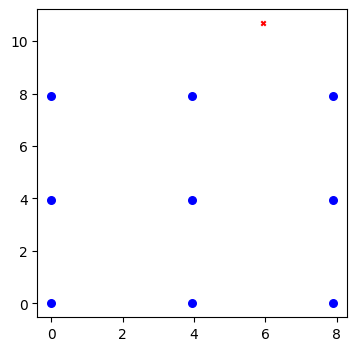

Epoch 1/200
Loss: 60.62200164794922 MeanGrad: [0.25161386 0.9622544 ]


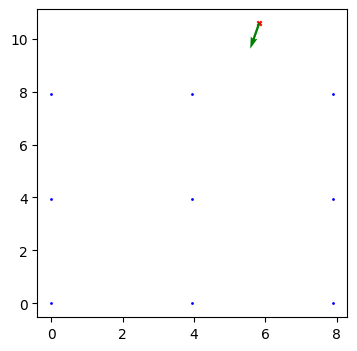

Epoch 2/200
Loss: 61.20525360107422 MeanGrad: [-5.618932 -9.378016]


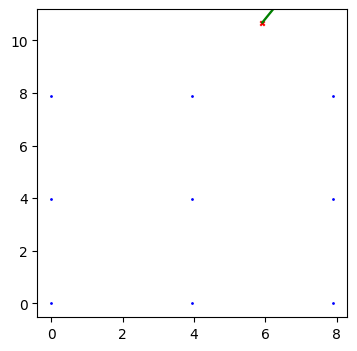

Epoch 3/200
Loss: 60.64021682739258 MeanGrad: [-0.9491443 -1.6134564]


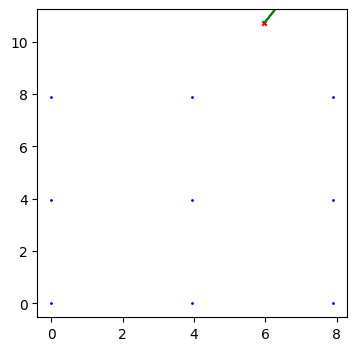

Epoch 4/200
Loss: 60.70794677734375 MeanGrad: [1.3634576 2.7710829]


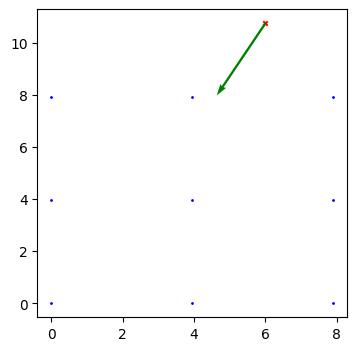

Epoch 5/200
Loss: 60.893741607666016 MeanGrad: [2.1843352 4.336507 ]


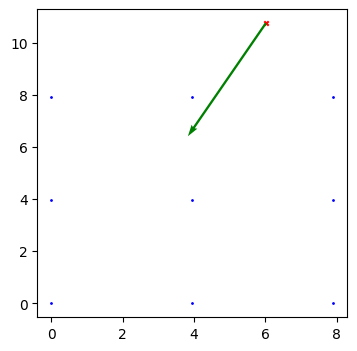

Epoch 6/200
Loss: 60.93470764160156 MeanGrad: [2.4376137 4.399675 ]


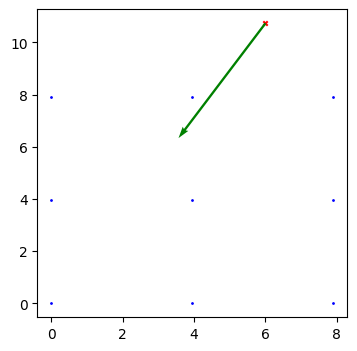

Epoch 7/200
Loss: 60.84334182739258 MeanGrad: [2.3591807 3.5759554]


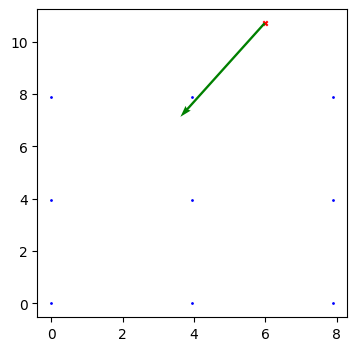

Epoch 8/200
Loss: 60.707828521728516 MeanGrad: [1.8874332 2.0512478]


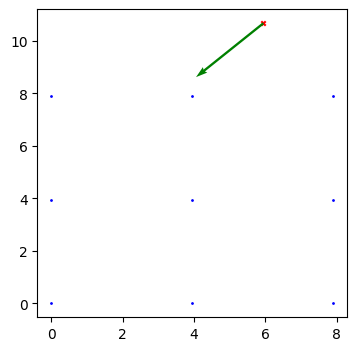

Epoch 9/200
Loss: 60.625160217285156 MeanGrad: [ 0.8900703  -0.07622337]


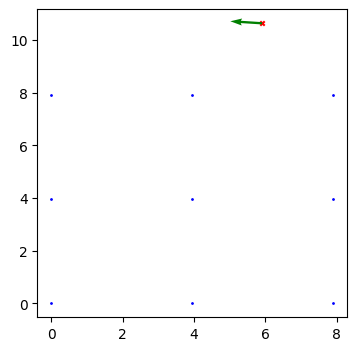

Epoch 10/200
Loss: 60.65396499633789 MeanGrad: [-0.59081054 -2.4419632 ]


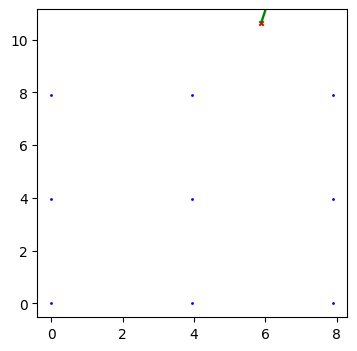

Epoch 11/200
Loss: 60.74281311035156 MeanGrad: [-2.0045226 -4.116789 ]


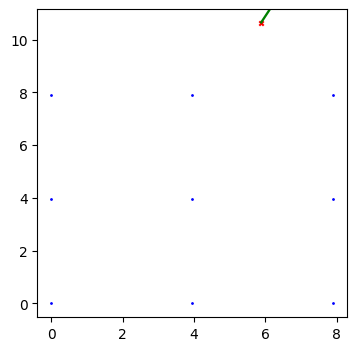

Epoch 12/200
Loss: 60.764949798583984 MeanGrad: [-2.5491478 -4.1640134]


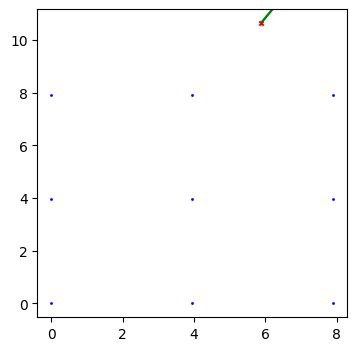

Epoch 13/200
Loss: 60.70024871826172 MeanGrad: [-2.1115613 -2.7101088]


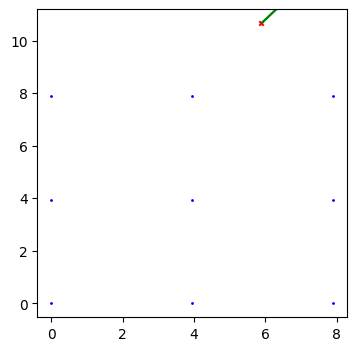

Epoch 14/200
Loss: 60.63484191894531 MeanGrad: [-1.1963835 -0.6719334]


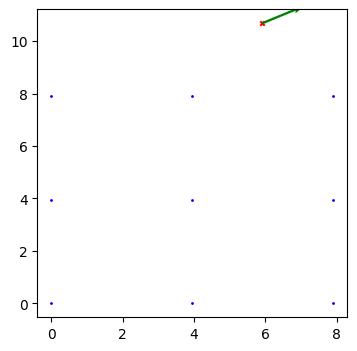

Epoch 15/200
Loss: 60.624847412109375 MeanGrad: [-0.273795   1.1183662]


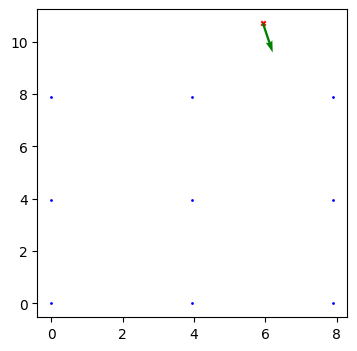

Epoch 16/200
Loss: 60.655601501464844 MeanGrad: [0.45349267 2.2571082 ]


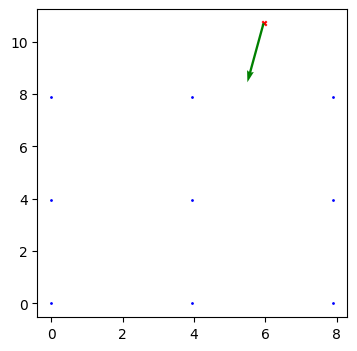

Epoch 17/200
Loss: 60.68565368652344 MeanGrad: [0.9604796 2.6832006]


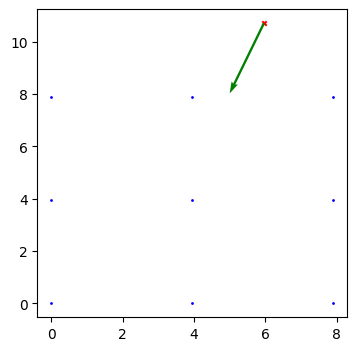

Epoch 18/200
Loss: 60.689727783203125 MeanGrad: [1.2642859 2.4882934]


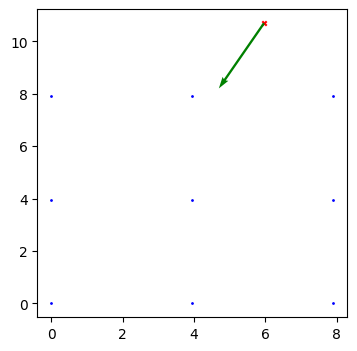

Epoch 19/200
Loss: 60.66854476928711 MeanGrad: [1.3572377 1.8014398]


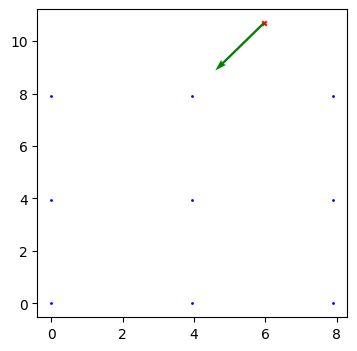

Epoch 20/200
Loss: 60.639678955078125 MeanGrad: [1.2030973 0.7680962]


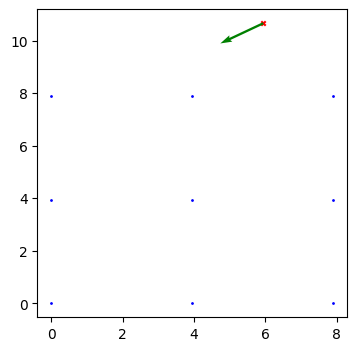

Epoch 21/200
Loss: 60.623565673828125 MeanGrad: [ 0.7761132  -0.42046604]


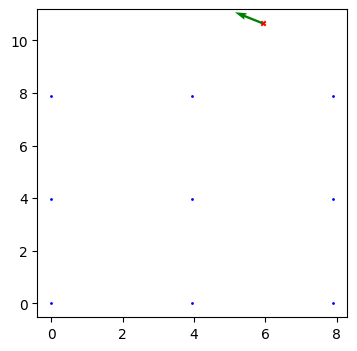

Epoch 22/200
Loss: 60.629112243652344 MeanGrad: [ 0.1298014 -1.4959329]


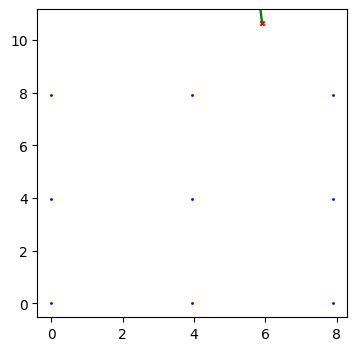

Epoch 23/200
Loss: 60.64567565917969 MeanGrad: [-0.55276483 -2.1432486 ]


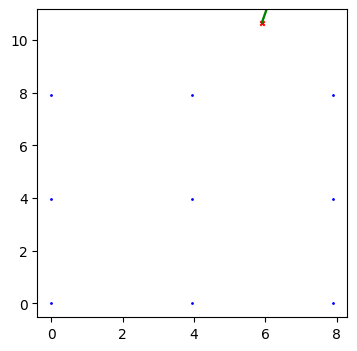

Epoch 24/200
Loss: 60.652610778808594 MeanGrad: [-1.0211039 -2.1351366]


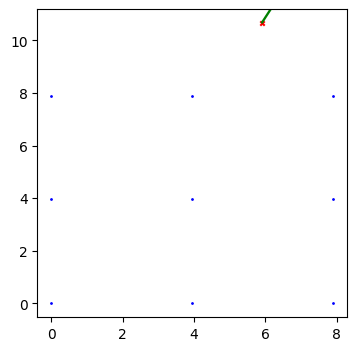

Epoch 25/200
Loss: 60.642032623291016 MeanGrad: [-1.12685   -1.4886286]


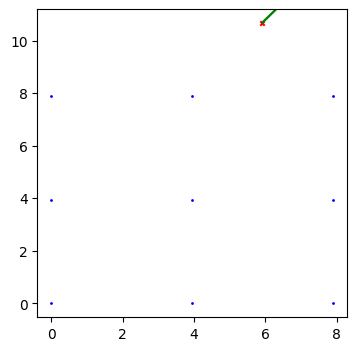

Epoch 26/200
Loss: 60.626407623291016 MeanGrad: [-0.91199005 -0.47456783]


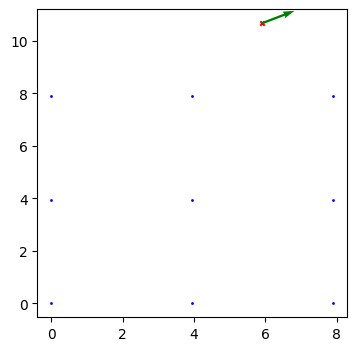

Epoch 27/200
Loss: 60.620849609375 MeanGrad: [-0.5262923   0.54272425]


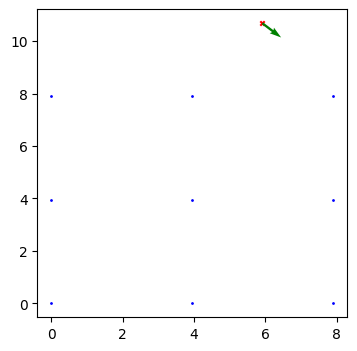

Epoch 28/200
Loss: 60.626548767089844 MeanGrad: [-0.1082387  1.2778443]


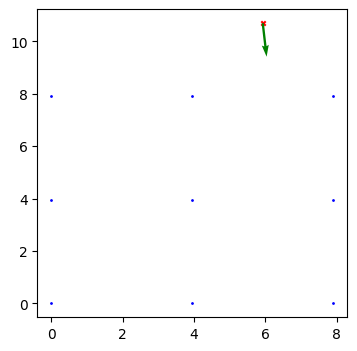

Epoch 29/200
Loss: 60.633785247802734 MeanGrad: [0.25982702 1.5914905 ]


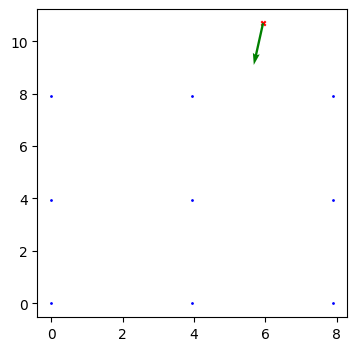

Epoch 30/200
Loss: 60.634342193603516 MeanGrad: [0.5346319 1.4700634]


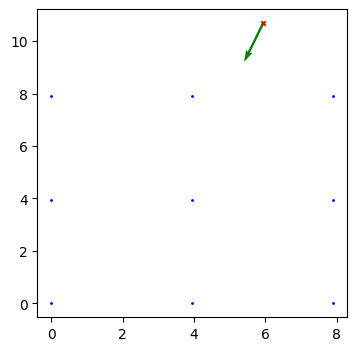

Epoch 31/200
Loss: 60.62821960449219 MeanGrad: [0.683809  0.9856269]


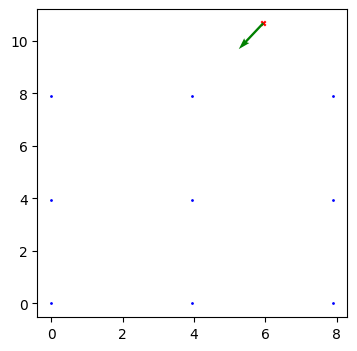

Epoch 32/200
Loss: 60.62141036987305 MeanGrad: [0.6766721  0.27430877]


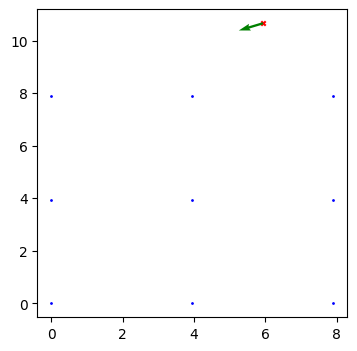

Epoch 33/200
Loss: 60.619407653808594 MeanGrad: [ 0.500539   -0.47487986]


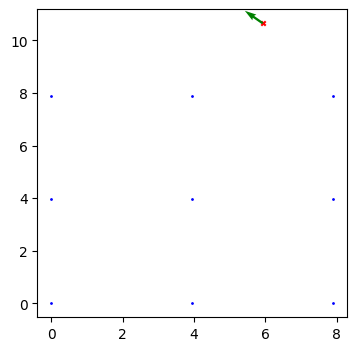

Epoch 34/200
Loss: 60.62229919433594 MeanGrad: [ 0.19120176 -1.0495142 ]


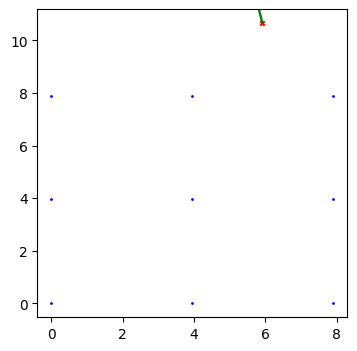

Epoch 35/200
Loss: 60.62528610229492 MeanGrad: [-0.15497446 -1.2772043 ]


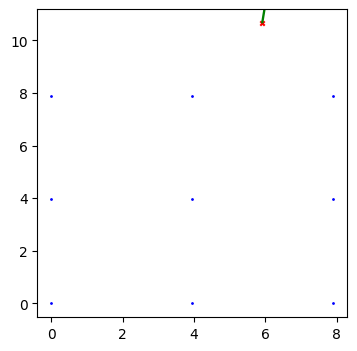

Epoch 36/200
Loss: 60.624267578125 MeanGrad: [-0.41807228 -1.09911   ]


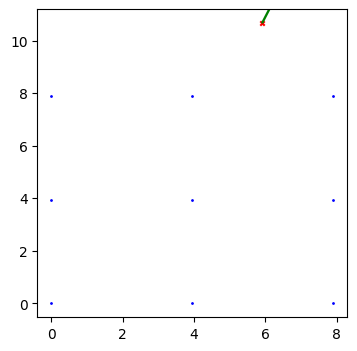

Epoch 37/200
Loss: 60.62025451660156 MeanGrad: [-0.5214979 -0.6002435]


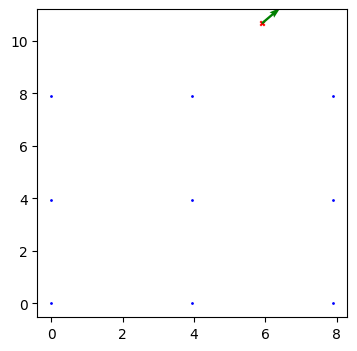

Epoch 38/200
Loss: 60.61760330200195 MeanGrad: [-0.4649699  0.0307328]


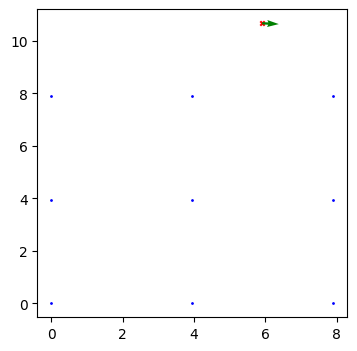

Epoch 39/200
Loss: 60.61846160888672 MeanGrad: [-0.30095473  0.5858491 ]


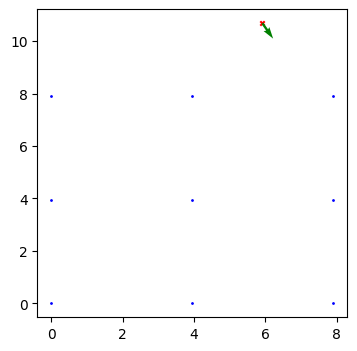

Epoch 40/200
Loss: 60.62067413330078 MeanGrad: [-0.09251541  0.9113566 ]


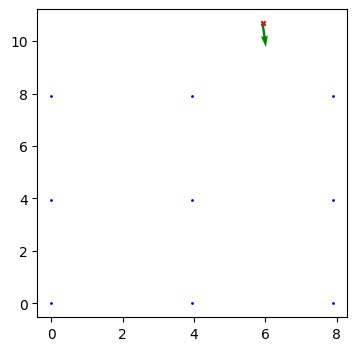

Epoch 41/200
Loss: 60.62098693847656 MeanGrad: [0.10887107 0.9396707 ]


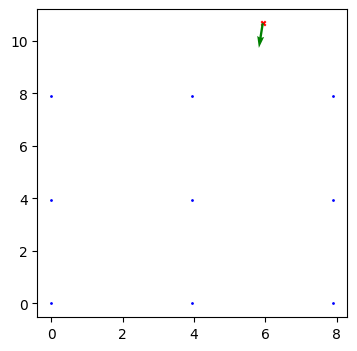

Epoch 42/200
Loss: 60.618892669677734 MeanGrad: [0.26401025 0.68822354]


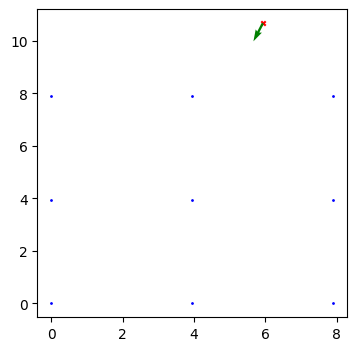

Epoch 43/200
Loss: 60.616661071777344 MeanGrad: [0.34151113 0.24614865]


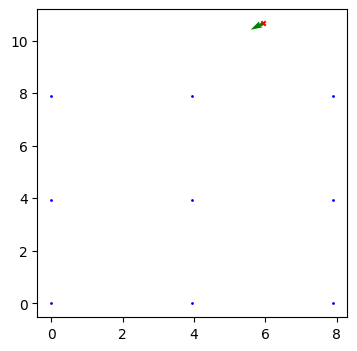

Epoch 44/200
Loss: 60.6164665222168 MeanGrad: [ 0.3217446  -0.24441007]


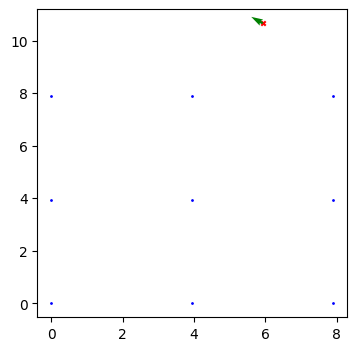

Epoch 45/200
Loss: 60.61784362792969 MeanGrad: [ 0.20957045 -0.62389666]


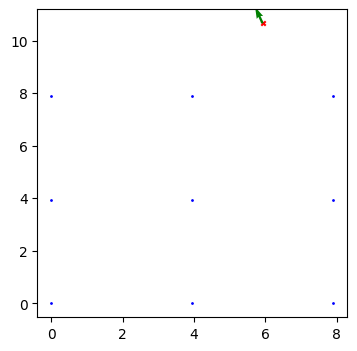

Epoch 46/200
Loss: 60.61859893798828 MeanGrad: [ 0.04335815 -0.770195  ]


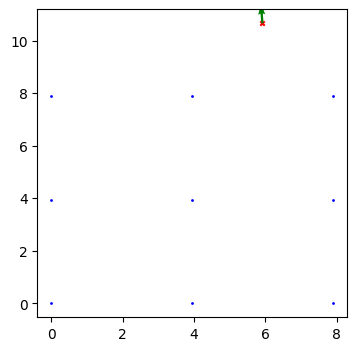

Epoch 47/200
Loss: 60.617584228515625 MeanGrad: [-0.11679969 -0.6486328 ]


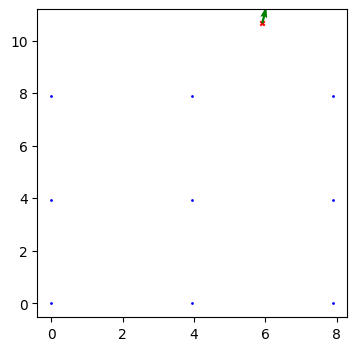

Epoch 48/200
Loss: 60.615966796875 MeanGrad: [-0.21844071 -0.32359064]


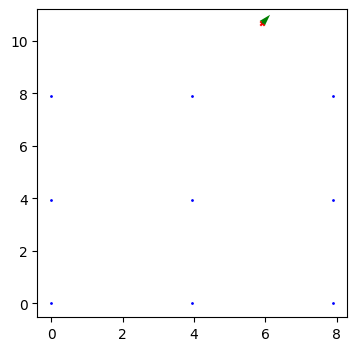

Epoch 49/200
Loss: 60.61552810668945 MeanGrad: [-0.24010934  0.07549203]


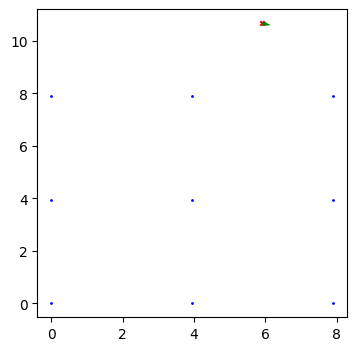

Epoch 50/200
Loss: 60.61641311645508 MeanGrad: [-0.19149199  0.41005087]


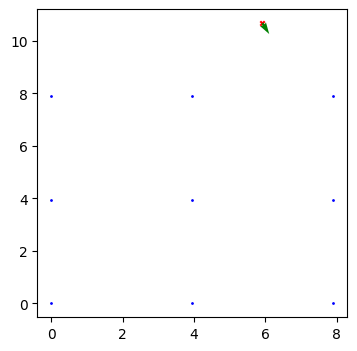

Epoch 51/200
Loss: 60.6171875 MeanGrad: [-0.0989321  0.5794054]


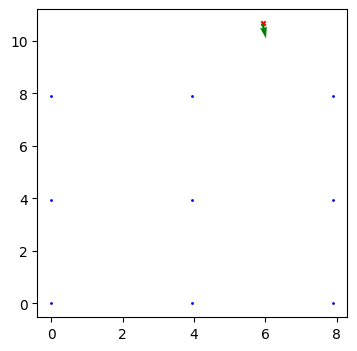

Epoch 52/200
Loss: 60.616737365722656 MeanGrad: [0.00771765 0.54445046]


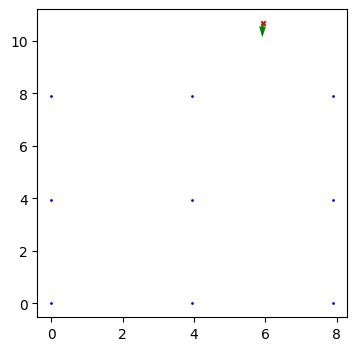

Epoch 53/200
Loss: 60.615577697753906 MeanGrad: [0.10068455 0.33106995]


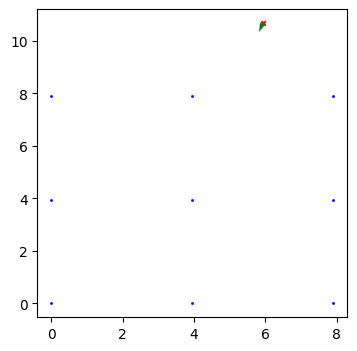

Epoch 54/200
Loss: 60.615028381347656 MeanGrad: [0.15651979 0.02022693]


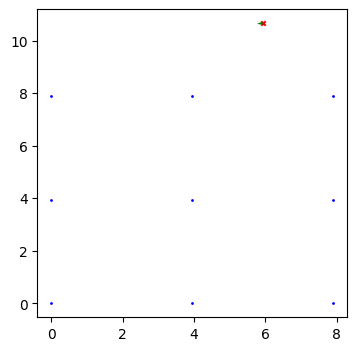

Epoch 55/200
Loss: 60.61555862426758 MeanGrad: [ 0.16071546 -0.2755787 ]


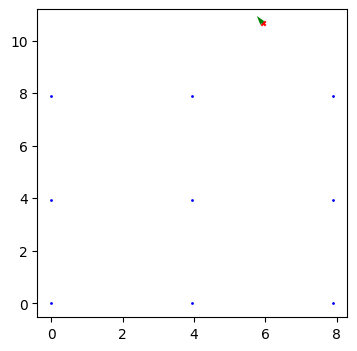

Epoch 56/200
Loss: 60.61622619628906 MeanGrad: [ 0.11448297 -0.4506463 ]


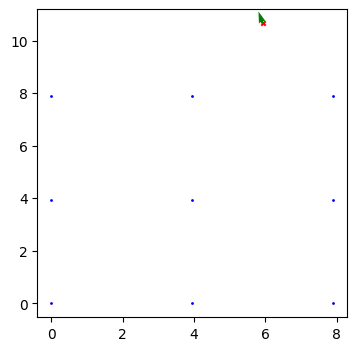

Epoch 57/200
Loss: 60.61605453491211 MeanGrad: [ 0.03719449 -0.4485041 ]


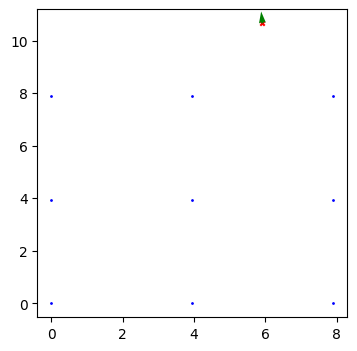

Epoch 58/200
Loss: 60.615257263183594 MeanGrad: [-0.04148433 -0.28488863]


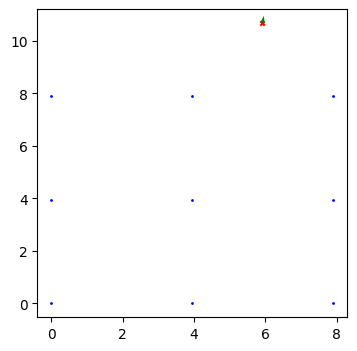

Epoch 59/200
Loss: 60.614830017089844 MeanGrad: [-0.09558176 -0.03522234]


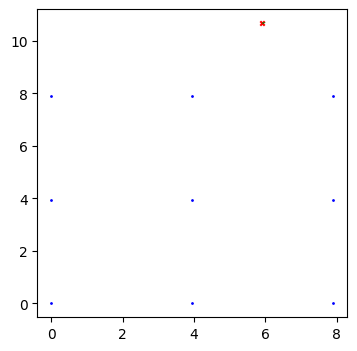

Epoch 60/200
Loss: 60.61516571044922 MeanGrad: [-0.11264233  0.20193693]


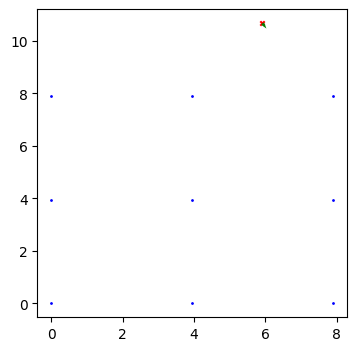

Epoch 61/200
Loss: 60.61565017700195 MeanGrad: [-0.09425438  0.3441766 ]


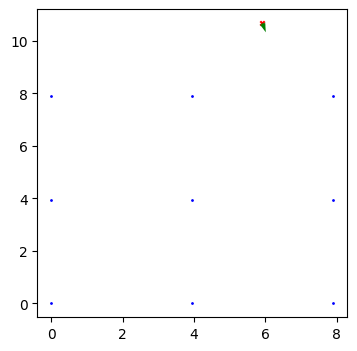

Epoch 62/200
Loss: 60.61558151245117 MeanGrad: [-0.05108237  0.35027874]


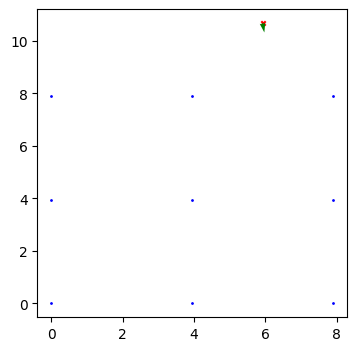

Epoch 63/200
Loss: 60.61505889892578 MeanGrad: [0.00191732 0.22894037]


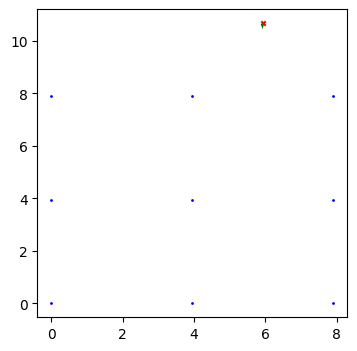

Epoch 64/200
Loss: 60.61474609375 MeanGrad: [0.04885344 0.03261082]


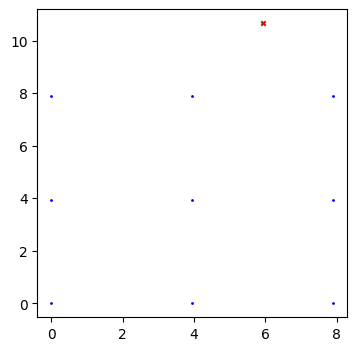

Epoch 65/200
Loss: 60.614959716796875 MeanGrad: [ 0.07604074 -0.16073832]


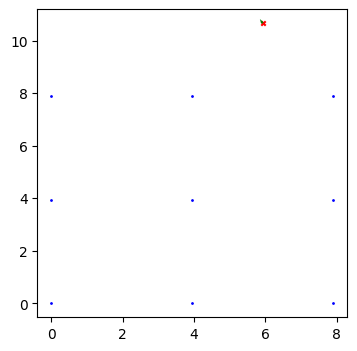

Epoch 66/200
Loss: 60.61529541015625 MeanGrad: [ 0.07616875 -0.27672568]


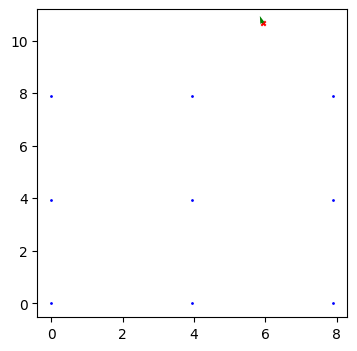

Epoch 67/200
Loss: 60.61524963378906 MeanGrad: [ 0.05156346 -0.27546304]


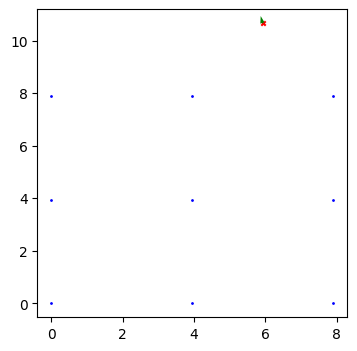

Epoch 68/200
Loss: 60.614898681640625 MeanGrad: [ 0.01333016 -0.1675672 ]


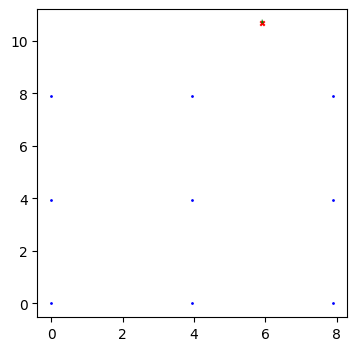

Epoch 69/200
Loss: 60.61471176147461 MeanGrad: [-0.02409807 -0.00550872]


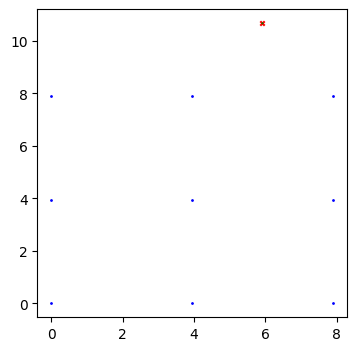

Epoch 70/200
Loss: 60.61487579345703 MeanGrad: [-0.04900983  0.14232615]


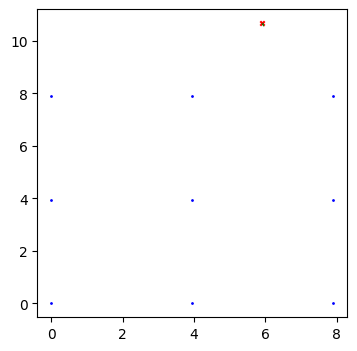

Epoch 71/200
Loss: 60.615081787109375 MeanGrad: [-0.05569953  0.22072971]


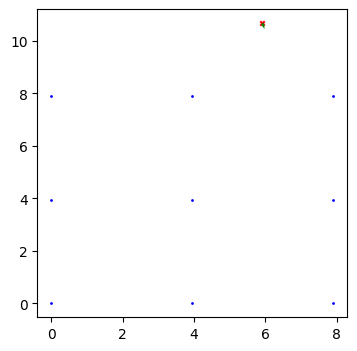

Epoch 72/200
Loss: 60.615020751953125 MeanGrad: [-0.04450177  0.20615333]


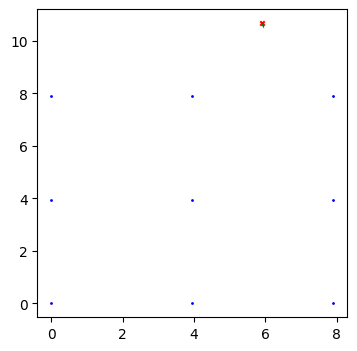

Epoch 73/200
Loss: 60.61479949951172 MeanGrad: [-0.02050251  0.11201932]


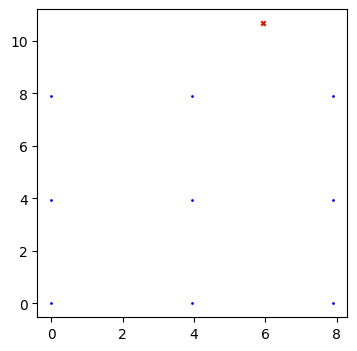

Epoch 74/200
Loss: 60.614707946777344 MeanGrad: [ 0.00795802 -0.01859106]


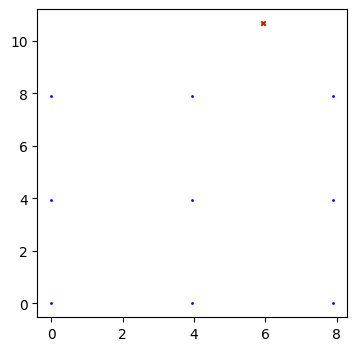

Epoch 75/200
Loss: 60.614830017089844 MeanGrad: [ 0.03147057 -0.1305579 ]


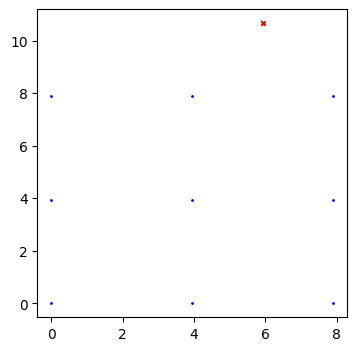

Epoch 76/200
Loss: 60.61494827270508 MeanGrad: [ 0.0424463 -0.1791792]


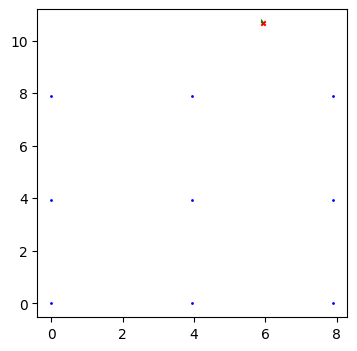

Epoch 77/200
Loss: 60.61487579345703 MeanGrad: [ 0.03804356 -0.14943211]


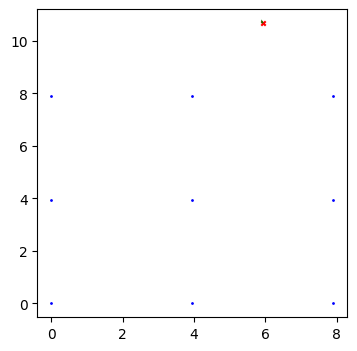

Epoch 78/200
Loss: 60.61473846435547 MeanGrad: [ 0.02114812 -0.06089443]


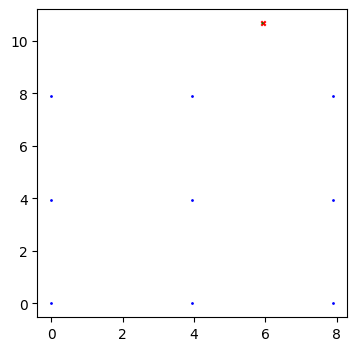

Epoch 79/200
Loss: 60.61471939086914 MeanGrad: [-0.00125773  0.04385734]


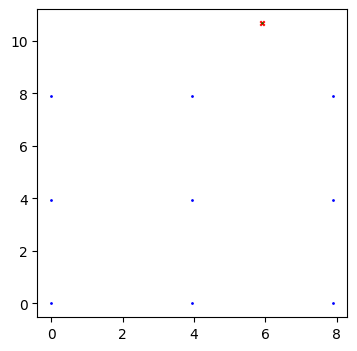

Epoch 80/200
Loss: 60.614810943603516 MeanGrad: [-0.02118013  0.1198916 ]


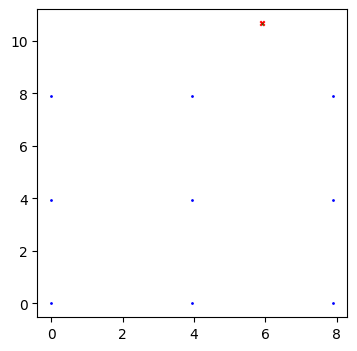

Epoch 81/200
Loss: 60.61485290527344 MeanGrad: [-0.03231413  0.13875467]


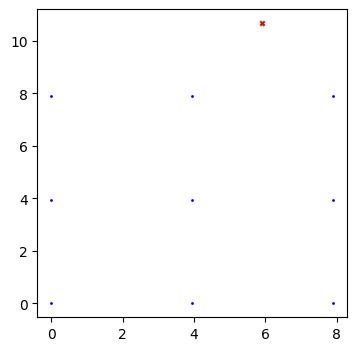

Epoch 82/200
Loss: 60.61478805541992 MeanGrad: [-0.03165916  0.09786208]


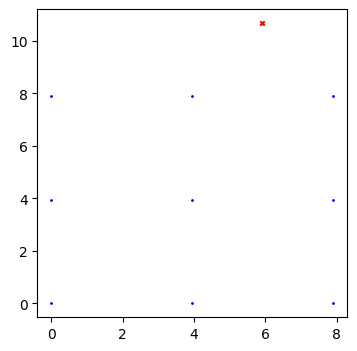

Epoch 83/200
Loss: 60.614715576171875 MeanGrad: [-0.02000707  0.01957717]


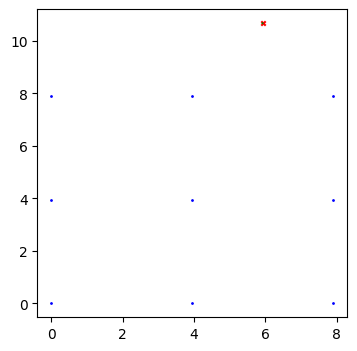

Epoch 84/200
Loss: 60.61472702026367 MeanGrad: [-0.00186253 -0.05986273]


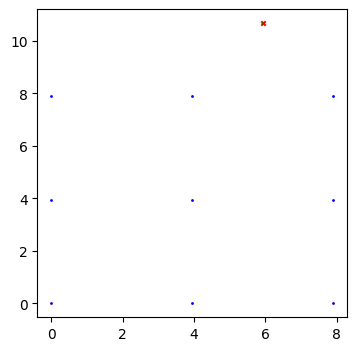

Epoch 85/200
Loss: 60.61478042602539 MeanGrad: [ 0.01591554 -0.10610344]


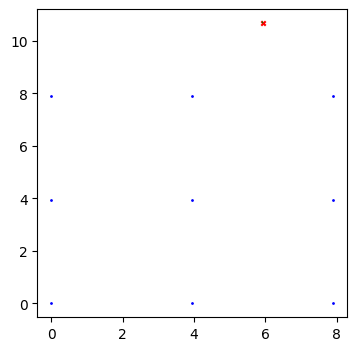

Epoch 86/200
Loss: 60.614784240722656 MeanGrad: [ 0.02672883 -0.10177594]


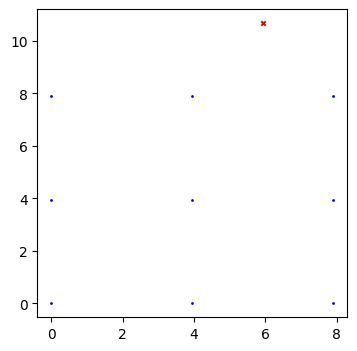

Epoch 87/200
Loss: 60.61473846435547 MeanGrad: [ 0.02688351 -0.05348971]


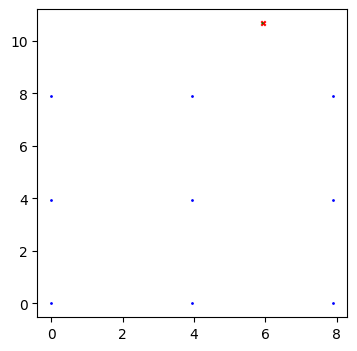

Epoch 88/200
Loss: 60.614707946777344 MeanGrad: [0.01696964 0.01330197]


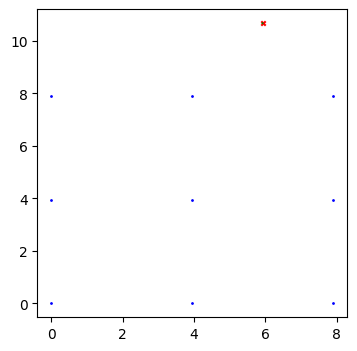

Epoch 89/200
Loss: 60.61473846435547 MeanGrad: [0.00135013 0.06741172]


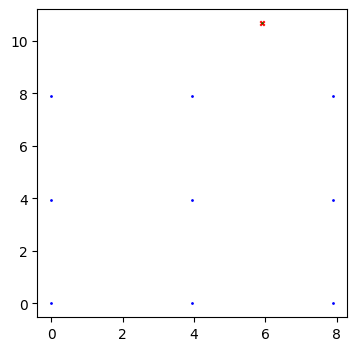

Epoch 90/200
Loss: 60.6147575378418 MeanGrad: [-0.01379201  0.0863722 ]


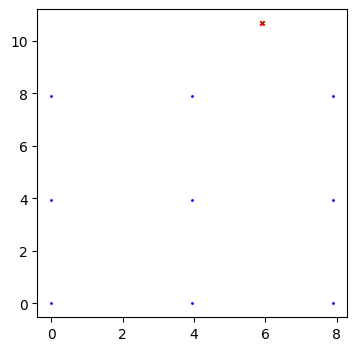

Epoch 91/200
Loss: 60.614742279052734 MeanGrad: [-0.02283447  0.06518865]


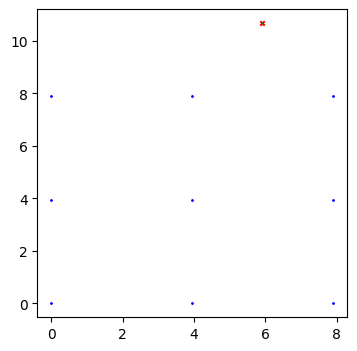

Epoch 92/200
Loss: 60.614715576171875 MeanGrad: [-0.02259281  0.01707202]


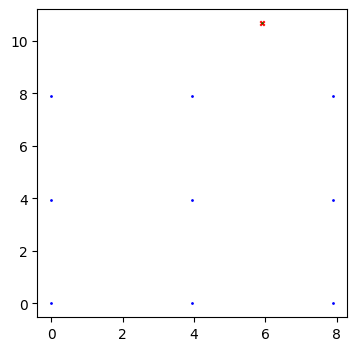

Epoch 93/200
Loss: 60.614715576171875 MeanGrad: [-0.01345022 -0.03405626]


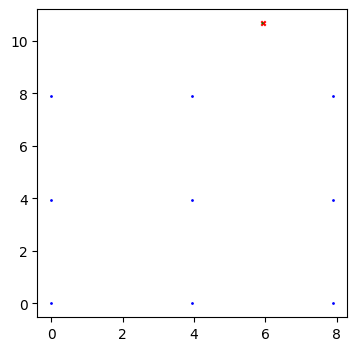

Epoch 94/200
Loss: 60.6147346496582 MeanGrad: [ 0.00062373 -0.0646997 ]


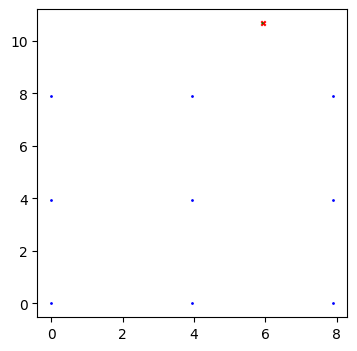

Epoch 95/200
Loss: 60.61473846435547 MeanGrad: [ 0.01368856 -0.062646  ]


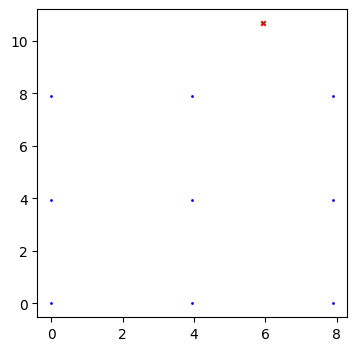

Epoch 96/200
Loss: 60.614715576171875 MeanGrad: [ 0.0203906  -0.03211157]


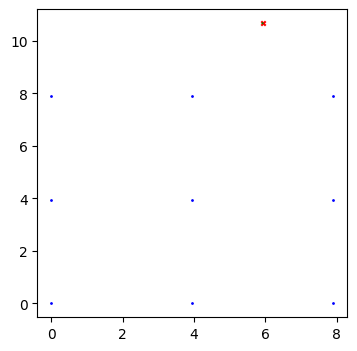

Epoch 97/200
Loss: 60.61471176147461 MeanGrad: [0.01838467 0.01008847]


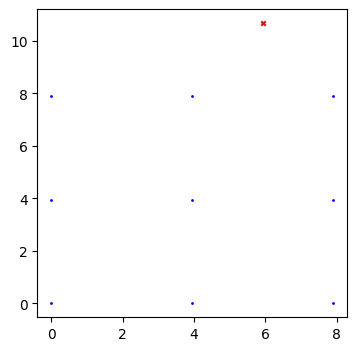

Epoch 98/200
Loss: 60.614723205566406 MeanGrad: [0.00894524 0.0432364 ]


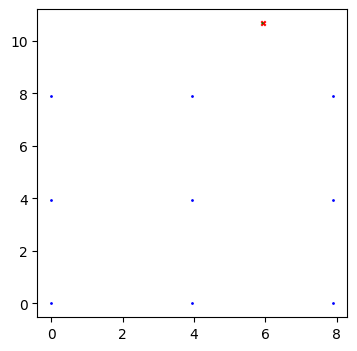

Epoch 99/200
Loss: 60.614723205566406 MeanGrad: [-0.00363783  0.05284882]


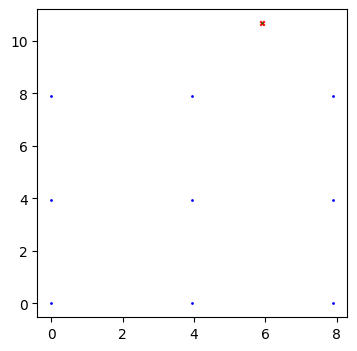

Epoch 100/200
Loss: 60.61471939086914 MeanGrad: [-0.01398739  0.03677389]


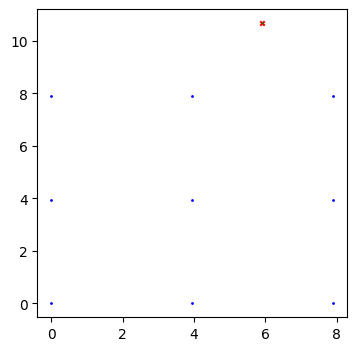

Epoch 101/200
Loss: 60.614707946777344 MeanGrad: [-0.01788112  0.00503933]


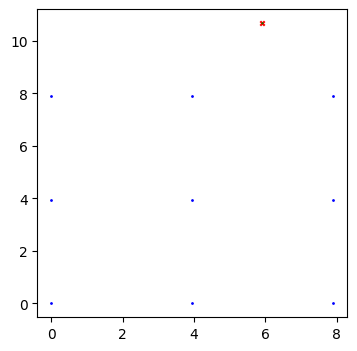

Epoch 102/200
Loss: 60.614707946777344 MeanGrad: [-0.01394297 -0.02582157]


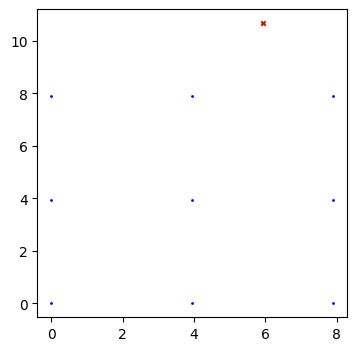

Epoch 103/200
Loss: 60.61471939086914 MeanGrad: [-0.00420116 -0.0411984 ]


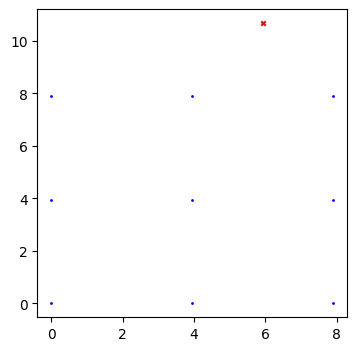

Epoch 104/200
Loss: 60.61471176147461 MeanGrad: [ 0.00679193 -0.03522402]


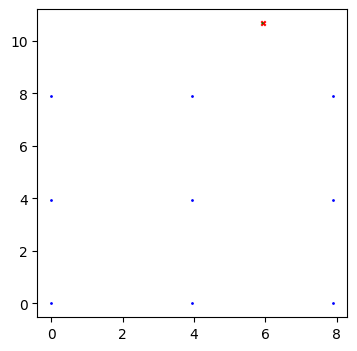

Epoch 105/200
Loss: 60.614707946777344 MeanGrad: [ 0.01409974 -0.0128882 ]


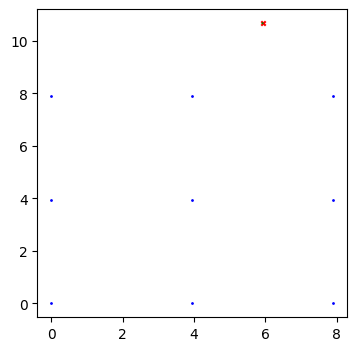

Epoch 106/200
Loss: 60.614707946777344 MeanGrad: [0.01476429 0.01335977]


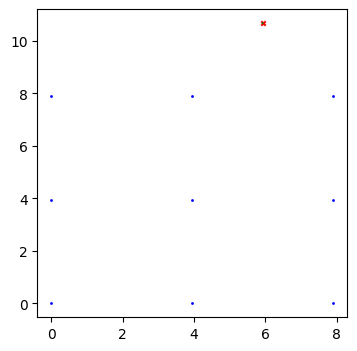

Epoch 107/200
Loss: 60.61471176147461 MeanGrad: [0.00890762 0.0303397 ]


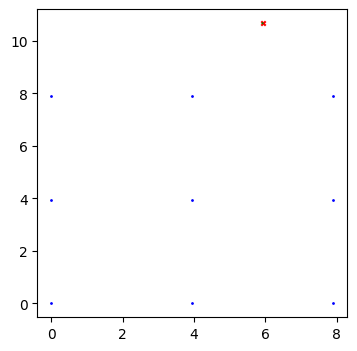

Epoch 108/200
Loss: 60.61471176147461 MeanGrad: [-0.00050014  0.03063619]


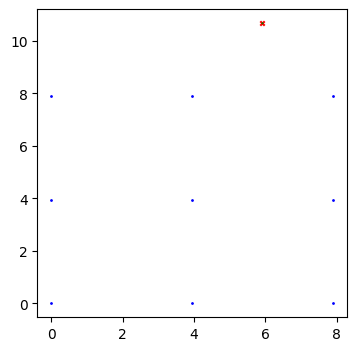

Epoch 109/200
Loss: 60.614707946777344 MeanGrad: [-0.00910237  0.01582334]


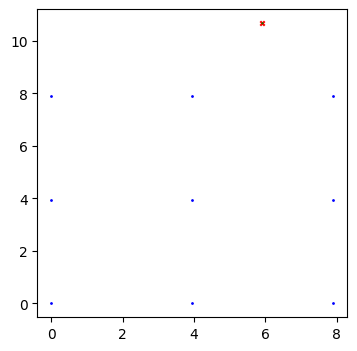

Epoch 110/200
Loss: 60.614707946777344 MeanGrad: [-0.01305896 -0.00529307]


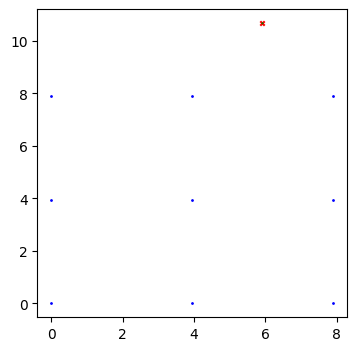

Epoch 111/200
Loss: 60.61471176147461 MeanGrad: [-0.01085171 -0.02151485]


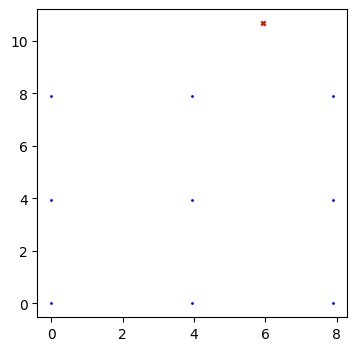

Epoch 112/200
Loss: 60.614715576171875 MeanGrad: [-0.00383261 -0.02523047]


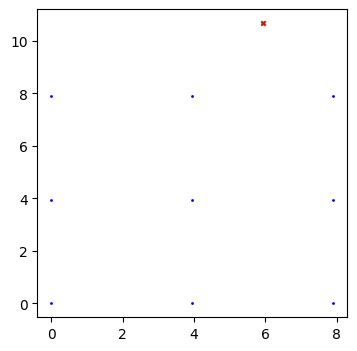

Epoch 113/200
Loss: 60.614707946777344 MeanGrad: [ 0.00445789 -0.01581463]


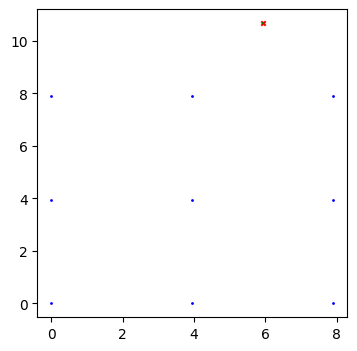

Epoch 114/200
Loss: 60.614707946777344 MeanGrad: [0.01009341 0.00062089]


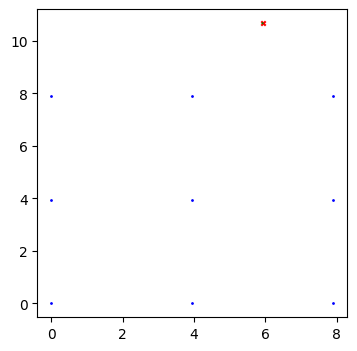

Epoch 115/200
Loss: 60.614707946777344 MeanGrad: [0.01066114 0.01492875]


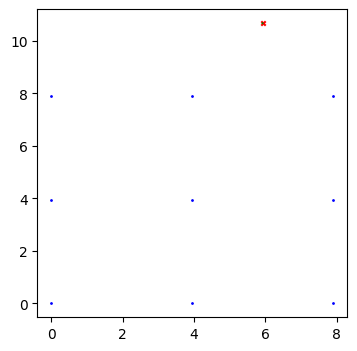

Epoch 116/200
Loss: 60.614707946777344 MeanGrad: [0.00623702 0.02008866]


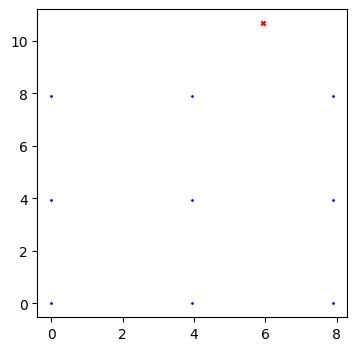

Epoch 117/200
Loss: 60.61470413208008 MeanGrad: [-0.00076366  0.01436458]


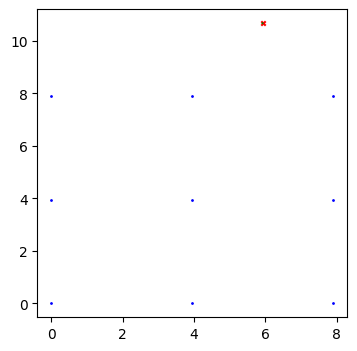

Epoch 118/200
Loss: 60.614707946777344 MeanGrad: [-0.00688635  0.00182542]


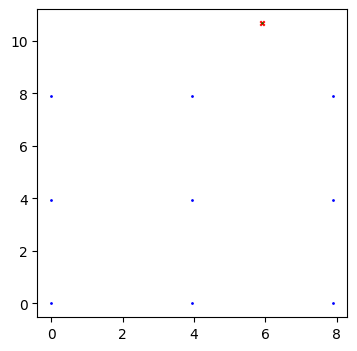

Epoch 119/200
Loss: 60.614707946777344 MeanGrad: [-0.00932391 -0.01033726]


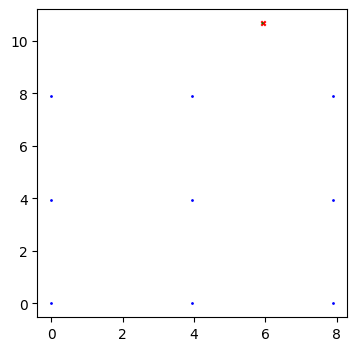

Epoch 120/200
Loss: 60.614707946777344 MeanGrad: [-0.00713006 -0.01580566]


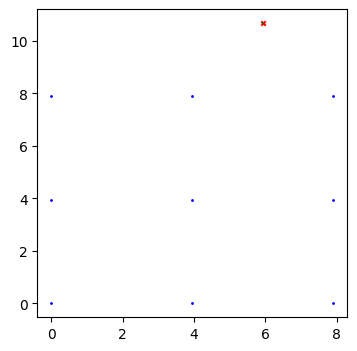

Epoch 121/200
Loss: 60.614707946777344 MeanGrad: [-0.00172177 -0.0124175 ]


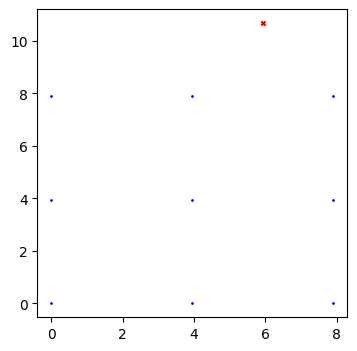

Epoch 122/200
Loss: 60.61470031738281 MeanGrad: [ 0.00410271 -0.00280184]


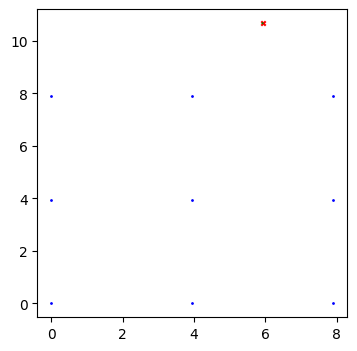

Epoch 123/200
Loss: 60.61470413208008 MeanGrad: [0.00747197 0.0072646 ]


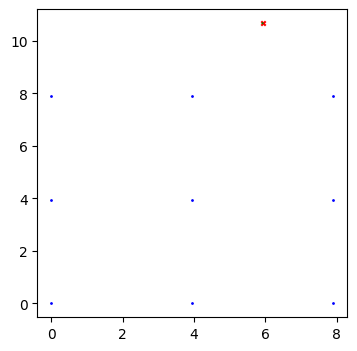

Epoch 124/200
Loss: 60.614707946777344 MeanGrad: [0.00698106 0.01245912]


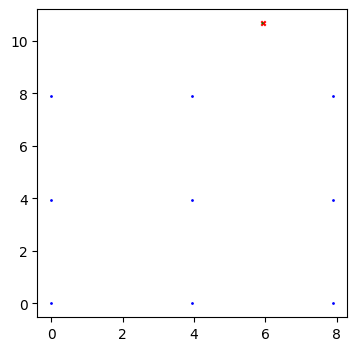

Epoch 125/200
Loss: 60.61470031738281 MeanGrad: [0.00312853 0.01038423]


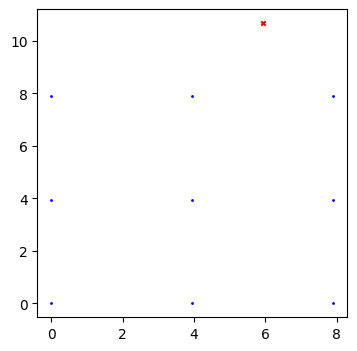

Epoch 126/200
Loss: 60.61470413208008 MeanGrad: [-0.00192263  0.00294227]


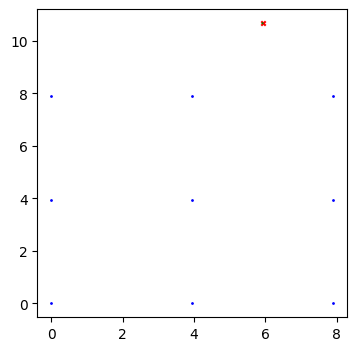

Epoch 127/200
Loss: 60.614707946777344 MeanGrad: [-0.00562833 -0.00535916]


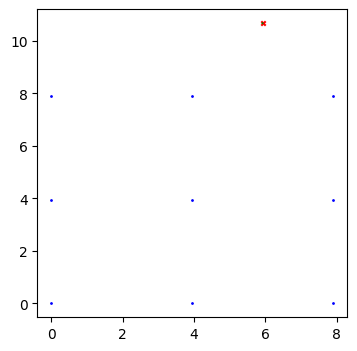

Epoch 128/200
Loss: 60.614707946777344 MeanGrad: [-0.00623006 -0.00986031]


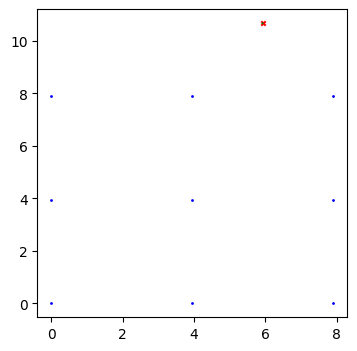

Epoch 129/200
Loss: 60.61470413208008 MeanGrad: [-0.00371894 -0.00849962]


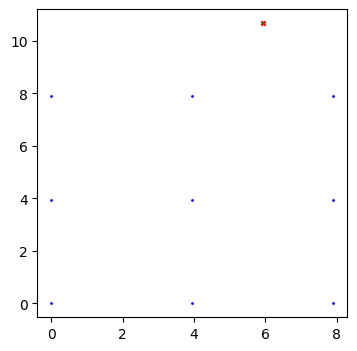

Epoch 130/200
Loss: 60.614707946777344 MeanGrad: [ 0.00043334 -0.00257595]


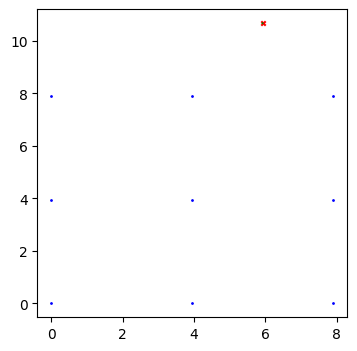

Epoch 131/200
Loss: 60.614707946777344 MeanGrad: [0.00399897 0.00417304]


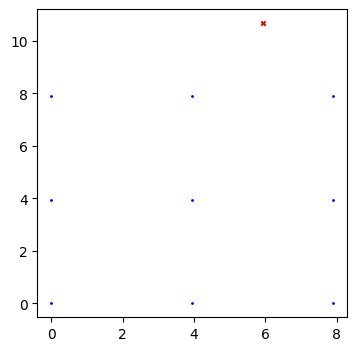

Epoch 132/200
Loss: 60.61470413208008 MeanGrad: [0.00523445 0.00789312]


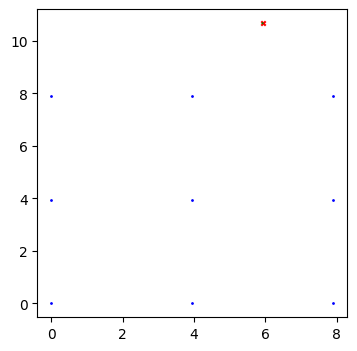

Epoch 133/200
Loss: 60.614707946777344 MeanGrad: [0.00375193 0.00685183]


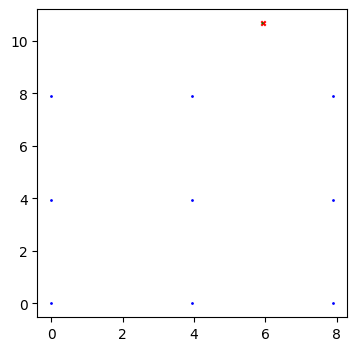

Epoch 134/200
Loss: 60.614707946777344 MeanGrad: [0.00050189 0.00203929]


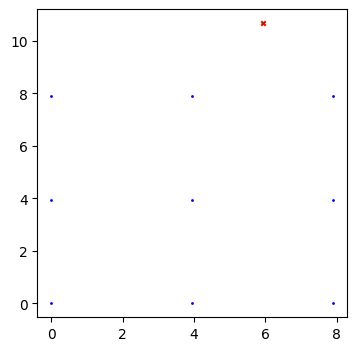

Epoch 135/200
Loss: 60.614707946777344 MeanGrad: [-0.002709   -0.00340903]


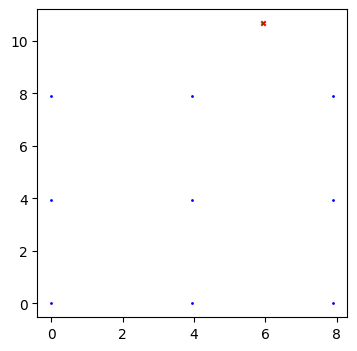

Epoch 136/200
Loss: 60.614707946777344 MeanGrad: [-0.00423272 -0.00638376]


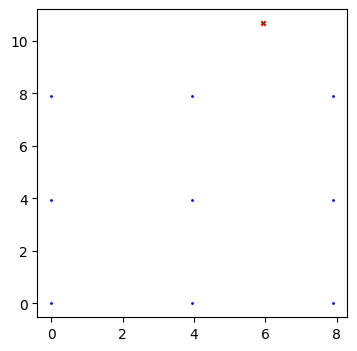

Epoch 137/200
Loss: 60.61470413208008 MeanGrad: [-0.00346362 -0.00543661]


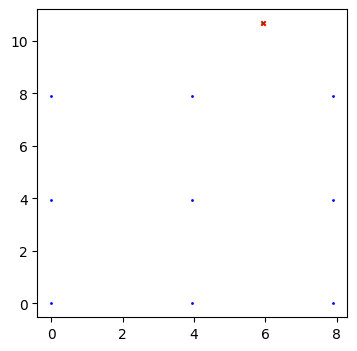

Epoch 138/200
Loss: 60.61470031738281 MeanGrad: [-0.00098522 -0.00148476]


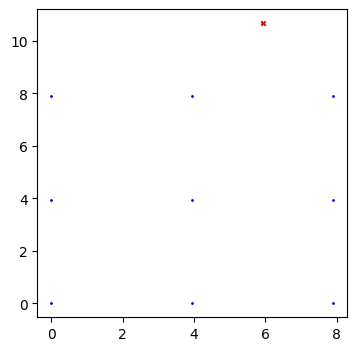

Epoch 139/200
Loss: 60.614707946777344 MeanGrad: [0.00174379 0.00294496]


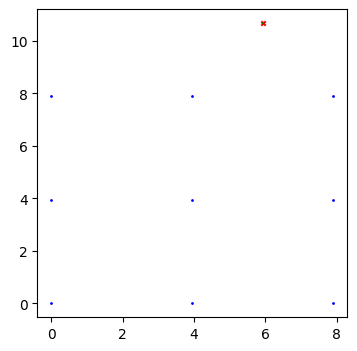

Epoch 140/200
Loss: 60.614707946777344 MeanGrad: [0.00331718 0.00520554]


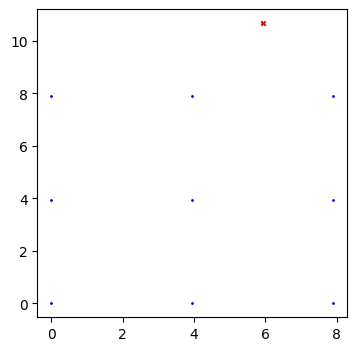

Epoch 141/200
Loss: 60.61470413208008 MeanGrad: [0.00303149 0.00426891]


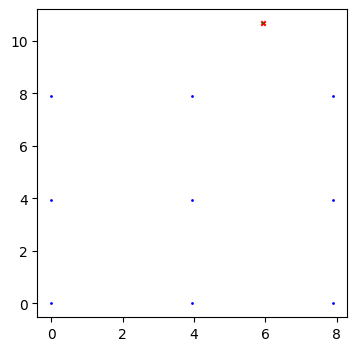

Epoch 142/200
Loss: 60.614707946777344 MeanGrad: [0.0012048  0.00093753]


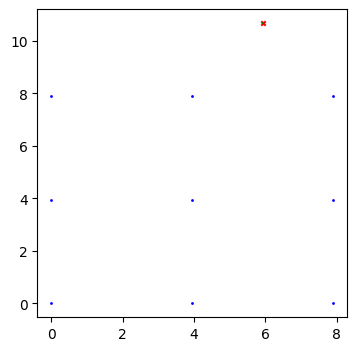

Epoch 143/200
Loss: 60.61470413208008 MeanGrad: [-0.00108393 -0.00262208]


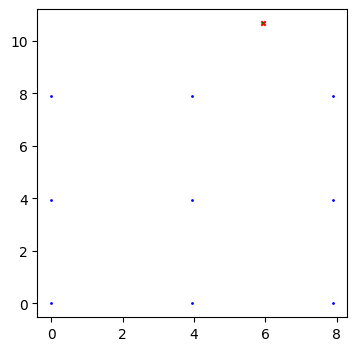

Epoch 144/200
Loss: 60.614707946777344 MeanGrad: [-0.00256038 -0.00432405]


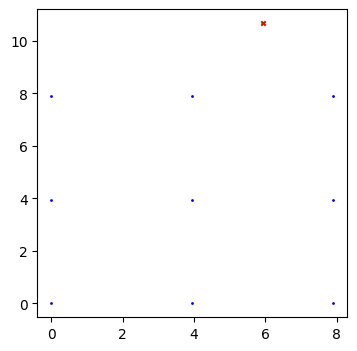

Epoch 145/200
Loss: 60.614707946777344 MeanGrad: [-0.00254014 -0.00332245]


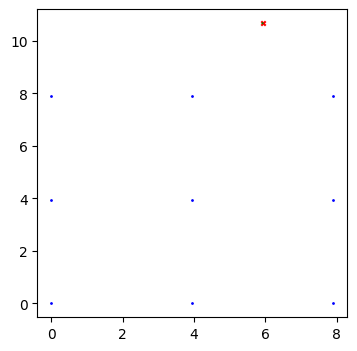

Epoch 146/200
Loss: 60.614707946777344 MeanGrad: [-0.00121237 -0.00044186]


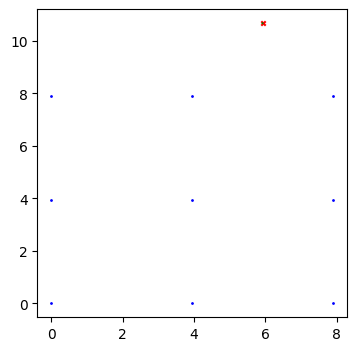

Epoch 147/200
Loss: 60.614707946777344 MeanGrad: [0.00063698 0.00239111]


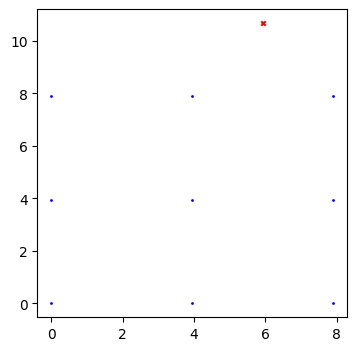

Epoch 148/200
Loss: 60.614707946777344 MeanGrad: [0.00193372 0.00359774]


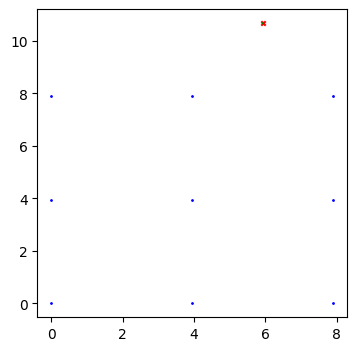

Epoch 149/200
Loss: 60.61470031738281 MeanGrad: [0.0020704 0.0025235]


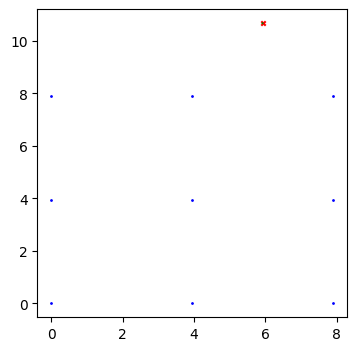

Epoch 150/200
Loss: 60.61470413208008 MeanGrad: [1.1030436e-03 8.1226230e-05]


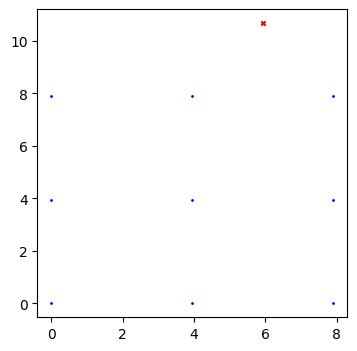

Epoch 151/200
Loss: 60.614707946777344 MeanGrad: [-0.00033298 -0.00224577]


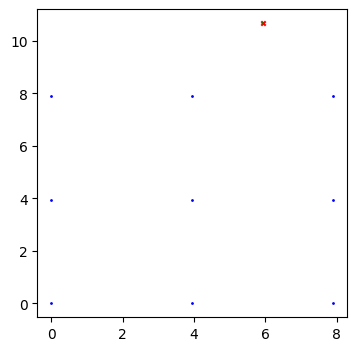

Epoch 152/200
Loss: 60.61470413208008 MeanGrad: [-0.00144466 -0.00298923]


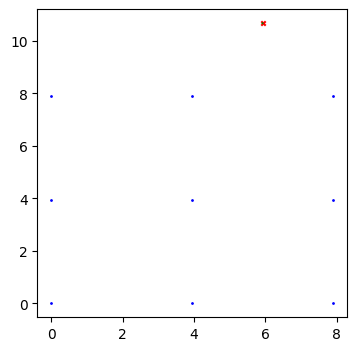

Epoch 153/200
Loss: 60.614707946777344 MeanGrad: [-0.00167182 -0.00188148]


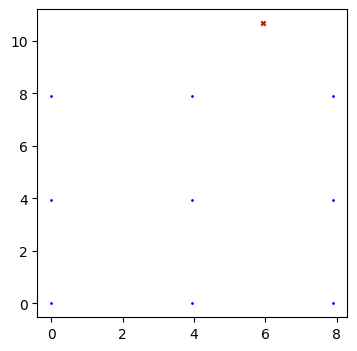

Epoch 154/200
Loss: 60.614707946777344 MeanGrad: [-0.00095536  0.00028674]


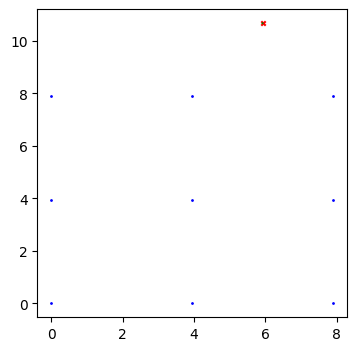

Epoch 155/200
Loss: 60.61470413208008 MeanGrad: [0.00018835 0.00210425]


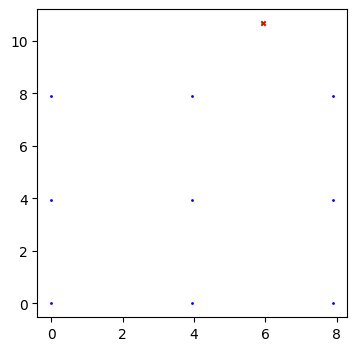

Epoch 156/200
Loss: 60.61470413208008 MeanGrad: [0.00108835 0.00250238]


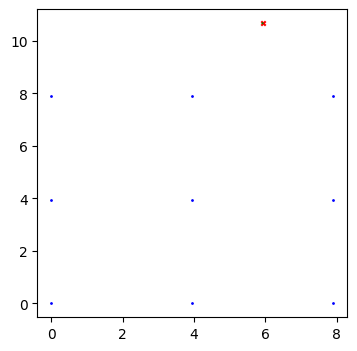

Epoch 157/200
Loss: 60.614707946777344 MeanGrad: [0.00130023 0.00129545]


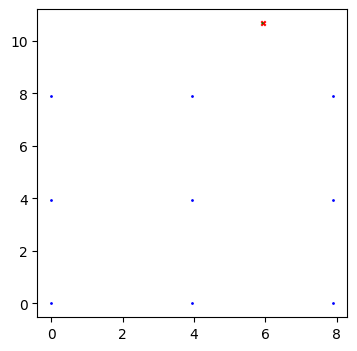

Epoch 158/200
Loss: 60.614707946777344 MeanGrad: [ 0.00078065 -0.00057621]


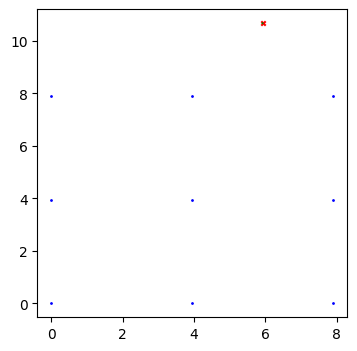

Epoch 159/200
Loss: 60.61470413208008 MeanGrad: [-0.00010252 -0.00196964]


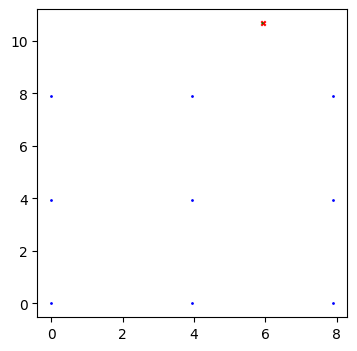

Epoch 160/200
Loss: 60.614707946777344 MeanGrad: [-0.00081508 -0.00197234]


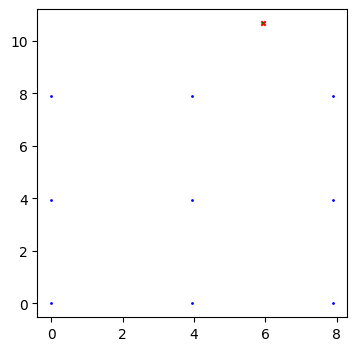

Epoch 161/200
Loss: 60.61470413208008 MeanGrad: [-0.00099841 -0.0007906 ]


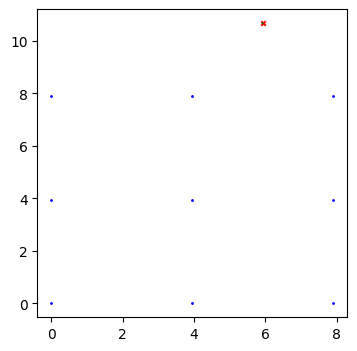

Epoch 162/200
Loss: 60.61470031738281 MeanGrad: [-0.00062146  0.00080213]


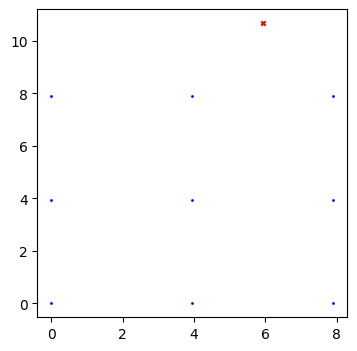

Epoch 163/200
Loss: 60.61470413208008 MeanGrad: [4.4599175e-05 1.7555431e-03]


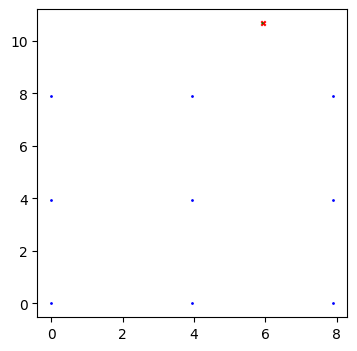

Epoch 164/200
Loss: 60.614707946777344 MeanGrad: [0.00060659 0.00147757]


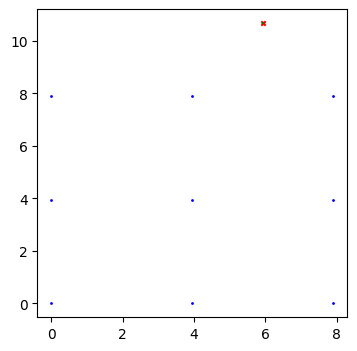

Epoch 165/200
Loss: 60.614707946777344 MeanGrad: [0.00076354 0.00034192]


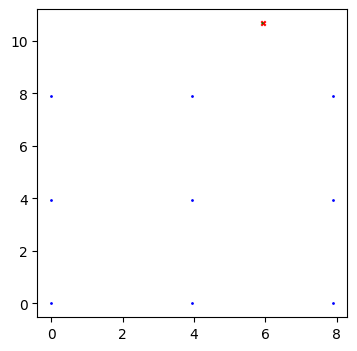

Epoch 166/200
Loss: 60.614707946777344 MeanGrad: [ 0.00047418 -0.00086945]


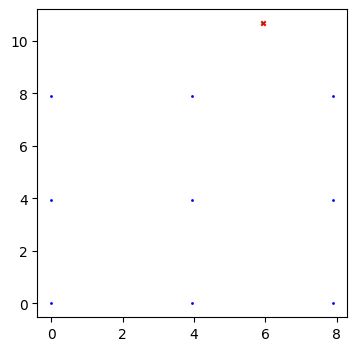

Epoch 167/200
Loss: 60.614707946777344 MeanGrad: [-1.8298626e-05 -1.4634132e-03]


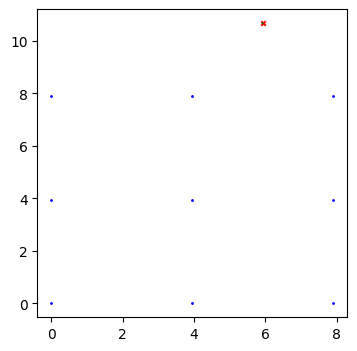

Epoch 168/200
Loss: 60.61470413208008 MeanGrad: [-0.00044495 -0.00110833]


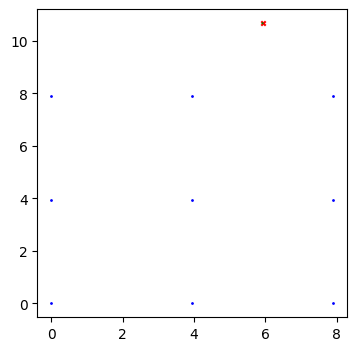

Epoch 169/200
Loss: 60.614707946777344 MeanGrad: [-5.7764724e-04 -5.6073070e-05]


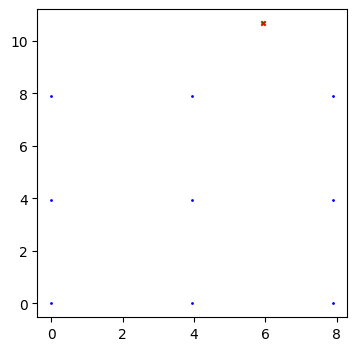

Epoch 170/200
Loss: 60.614707946777344 MeanGrad: [-0.00035347  0.00095466]


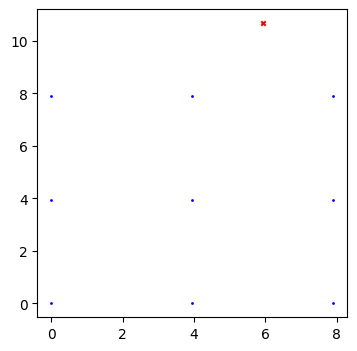

Epoch 171/200
Loss: 60.61470413208008 MeanGrad: [1.2939796e-05 1.2491941e-03]


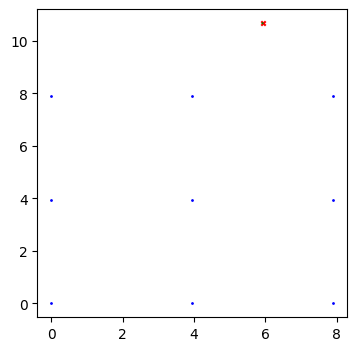

Epoch 172/200
Loss: 60.614707946777344 MeanGrad: [0.00032828 0.00069691]


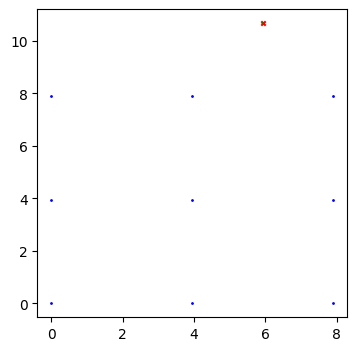

Epoch 173/200
Loss: 60.614707946777344 MeanGrad: [ 0.00041546 -0.00023357]


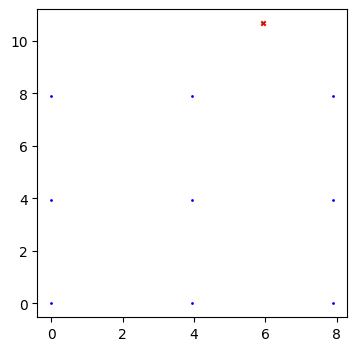

Epoch 174/200
Loss: 60.61470031738281 MeanGrad: [ 0.00027048 -0.0009496 ]


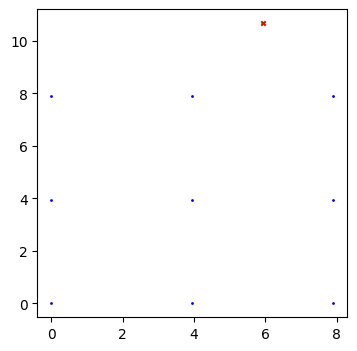

Epoch 175/200
Loss: 60.614707946777344 MeanGrad: [ 7.5672287e-06 -9.6178707e-04]


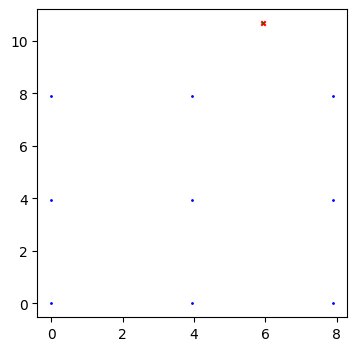

Epoch 176/200
Loss: 60.614707946777344 MeanGrad: [-0.00022998 -0.00039238]


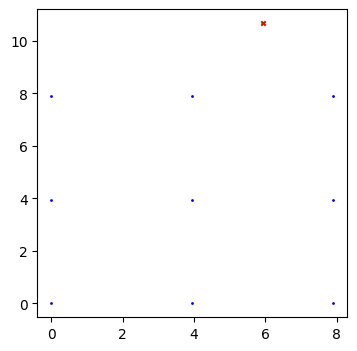

Epoch 177/200
Loss: 60.614707946777344 MeanGrad: [-0.00031116  0.00037911]


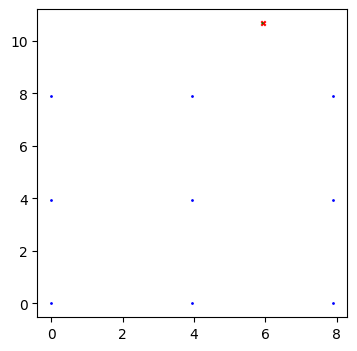

Epoch 178/200
Loss: 60.614707946777344 MeanGrad: [-0.00021076  0.00089915]


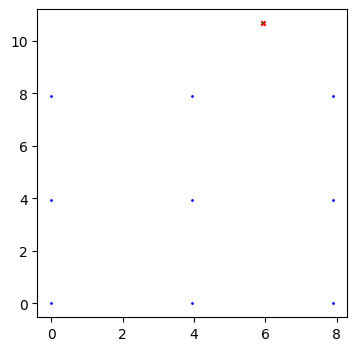

Epoch 179/200
Loss: 60.614707946777344 MeanGrad: [-9.6261501e-06  7.4625015e-04]


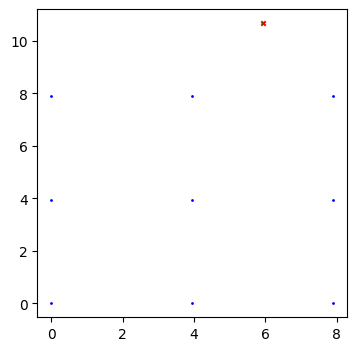

Epoch 180/200
Loss: 60.61470031738281 MeanGrad: [0.00015005 0.00011979]


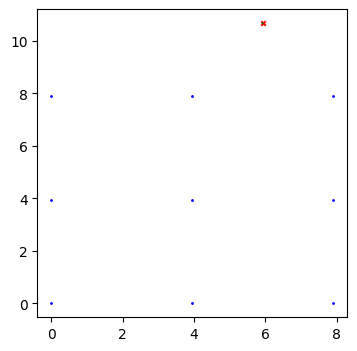

Epoch 181/200
Loss: 60.614707946777344 MeanGrad: [ 0.0002343  -0.00053313]


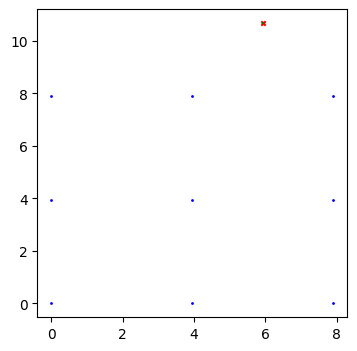

Epoch 182/200
Loss: 60.614707946777344 MeanGrad: [ 0.00017449 -0.00074146]


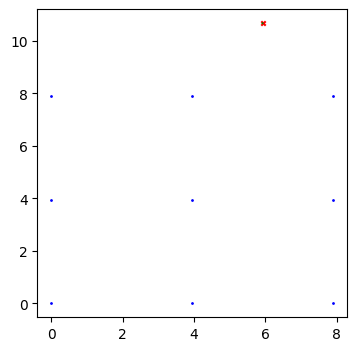

Epoch 183/200
Loss: 60.61470413208008 MeanGrad: [ 1.2580305e-05 -4.6186522e-04]


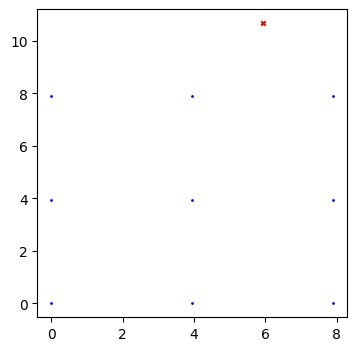

Epoch 184/200
Loss: 60.61470413208008 MeanGrad: [-0.00011525  0.00010434]


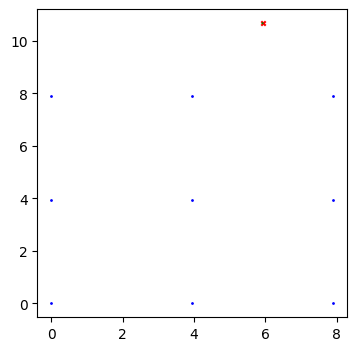

Epoch 185/200
Loss: 60.614707946777344 MeanGrad: [-0.0001757   0.00053028]


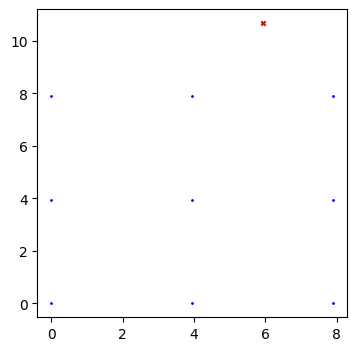

Epoch 186/200
Loss: 60.61470413208008 MeanGrad: [-0.00014517  0.00059831]


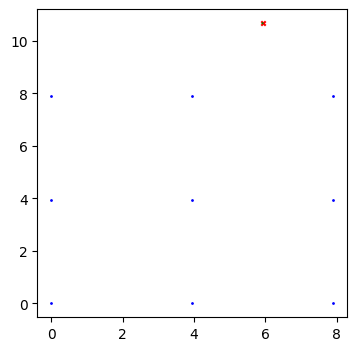

Epoch 187/200
Loss: 60.61470413208008 MeanGrad: [-1.463294e-05  2.462268e-04]


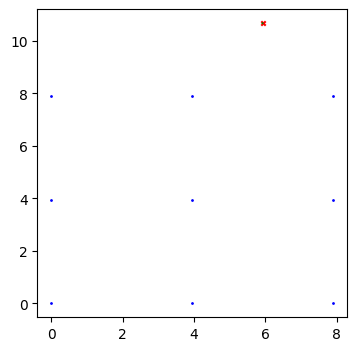

Epoch 188/200
Loss: 60.614707946777344 MeanGrad: [ 8.9788111e-05 -2.4740002e-04]


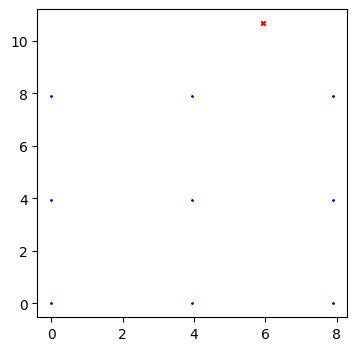

Epoch 189/200
Loss: 60.61470413208008 MeanGrad: [ 0.00014311 -0.00053473]


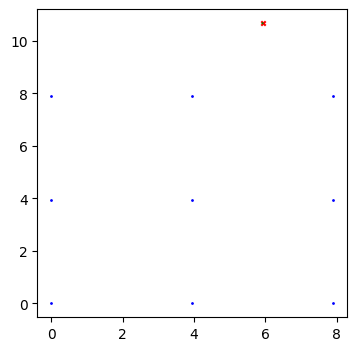

Epoch 190/200
Loss: 60.61470413208008 MeanGrad: [ 0.00011208 -0.00038324]


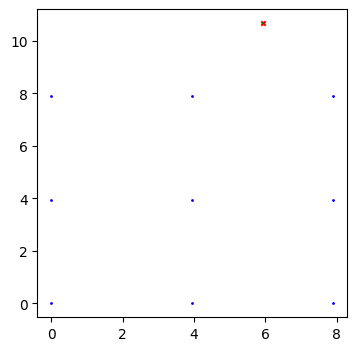

Epoch 191/200
Loss: 60.614707946777344 MeanGrad: [ 2.7745962e-05 -2.8336421e-05]


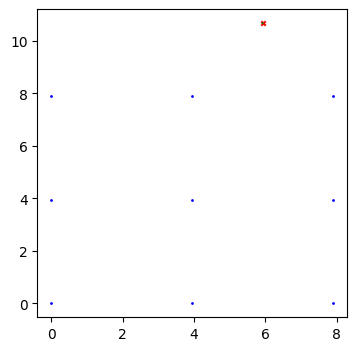

Epoch 192/200
Loss: 60.614707946777344 MeanGrad: [-6.850809e-05  3.219992e-04]


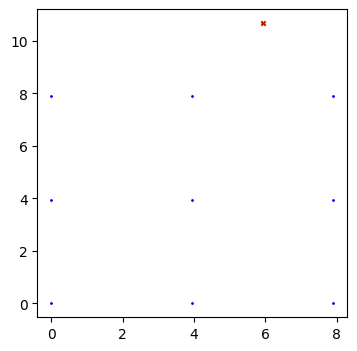

Epoch 193/200
Loss: 60.61470413208008 MeanGrad: [-0.00011805  0.00039148]


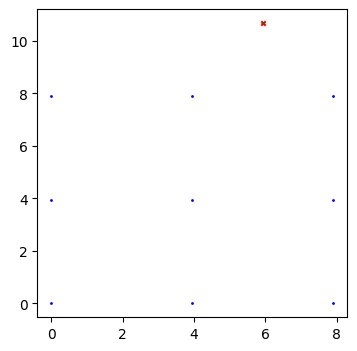

Epoch 194/200
Loss: 60.614707946777344 MeanGrad: [-0.00011437  0.00017071]


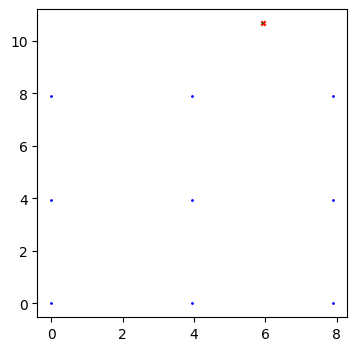

Epoch 195/200
Loss: 60.614707946777344 MeanGrad: [-2.5689602e-05 -1.0406971e-04]


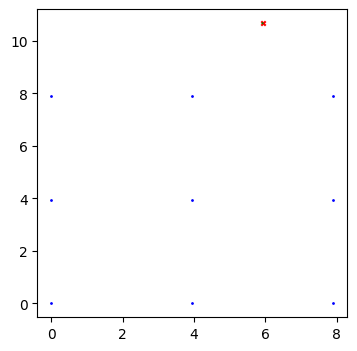

Epoch 196/200
Loss: 60.61470413208008 MeanGrad: [ 6.2782317e-05 -3.1366944e-04]


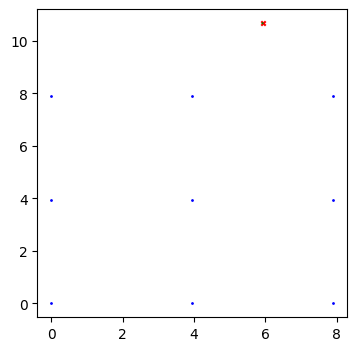

Epoch 197/200
Loss: 60.61470413208008 MeanGrad: [ 0.00011838 -0.00023499]


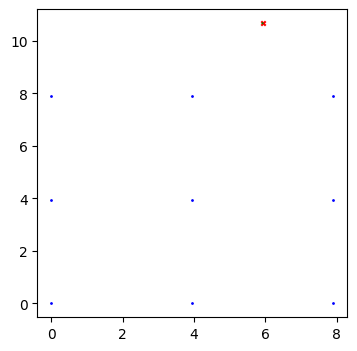

Epoch 198/200
Loss: 60.614707946777344 MeanGrad: [ 8.8203698e-05 -2.9921532e-05]


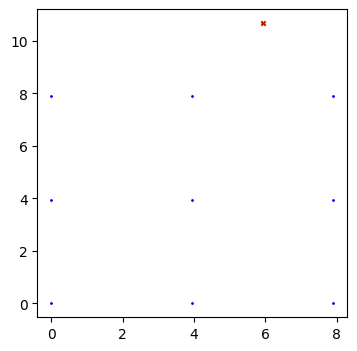

Epoch 199/200
Loss: 60.61470413208008 MeanGrad: [1.7344952e-05 1.7690659e-04]


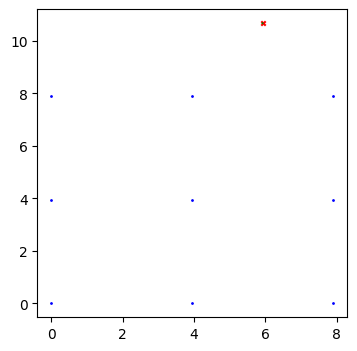

Epoch 200/200
Loss: 60.61470413208008 MeanGrad: [-5.5167824e-05  2.5410578e-04]
System Energy: -18.482291386081044 Last Loss: 60.61470413208008
distance traveled: [[-0.00660944 -0.01323414]]


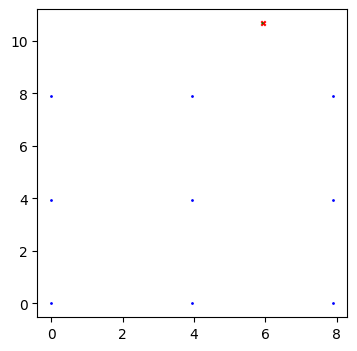

In [ ]:
ion_ =  ion.numpy()
plt.figure(figsize=(4,4))
plt.scatter(fcc_positions[:,0],fcc_positions[:,1],c = 'b',s=30)
plt.scatter(ion_[:,0],ion_[:,1],c = 'r',s=10,marker='x')
plt.show()
# Custom training loop
eta0 = 0.1
batch_size = 256
epochs = 200
decay_rate = 0.20
optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)
starting_pos =ion_.copy()
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    #optimizer.learning_rate = eta
    for x_batch in tf.data.Dataset.from_tensor_slices(sample_atoms).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(ion)
        H_loss_ = H_loss(ion,x_batch)
      grad_ = g.gradient(H_loss_, ion)
      optimizer.apply_gradients(zip([grad_], [ion]))#El gradiente es muy peuqeño, quiza jugando con las unidades¿?
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    ion_ =  ion.numpy()
    gradN = -10*eta0*grad_.numpy()

    plt.figure(figsize=(4,4))
    plt.scatter(fcc_positions[:,0],fcc_positions[:,1],c = 'b',s=1)
    plt.scatter(ion_[:,0],ion_[:,1],c = 'r',s=10,marker='x')
    plt.quiver(ion_[:,0],ion_[:,1], gradN[:,0], gradN[:,1], color='g', scale=1, scale_units='xy', angles='xy', label='Gradient Vectors')
    plt.show()

    if epoch+1==epochs:
      last_loss = H_loss_.numpy()
      system_energy = last_loss-(num_atoms*num_iones*Epsilon)

In [ ]:
print(f'minima distancia para que no haya superposicion:{Sigma:.3f} A ',f'profundidad del pozo: {-Epsilon: .3f} j/mol')
print(f'Atomos en la muestra:{num_atoms}',f'Iones a adsorber:{num_iones}')
print(f'energía del sistema:{system_energy:.3f} j/mol',f'minima energía posible: {-Epsilon*num_atoms*num_iones:.3f} j/mol')
print(f'distance traveled: {ion_-starting_pos}')

minima distancia para que no haya superposicion:3.035 A  profundidad del pozo: -8.789 j/mol
Atomos en la muestra:9 Iones a adsorber:1
energía del sistema:-18.482 j/mol minima energía posible: -79.097 j/mol
distance traveled: [[-0.00660944 -0.01323414]]
